# Data loading

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from pydmd import DMD

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [2]:
# load data
ds_slp = xr.open_dataset('./data/slp.nc') # change to 't2m.nc' for temperature data
ds_t2m = xr.open_dataset('./data/t2m.nc')

# 1. PCA for Spatial Dimensionality Reduction

## 1.1 Principal Component Analysis with 95% Explained Variance Retention

In [3]:
data_msl = ds_slp["msl"].values
data_t2m = ds_t2m["t2m"].values
ntime, nlat, nlon = data_t2m.shape

# Dimensional Reconstruction: Snapshot × Spatial Vector
msl = data_msl.reshape(ntime, -1)
t2m = data_t2m.reshape(ntime, -1)

# PCA Implementation
n_components = 15

# SLP DATA
pca1 = PCA(n_components=n_components)
msl_pca = pca1.fit_transform(msl)
msl_ratio = pca1.explained_variance_ratio_
msl_cumulative_ratio = np.cumsum(msl_ratio)

# T2M DATA
pca2 = PCA(n_components=n_components)
t2m_pca = pca2.fit_transform(t2m)
t2m_ratio = pca2.explained_variance_ratio_
t2m_cumulative_ratio = np.cumsum(t2m_ratio)

threshold = 0.95
x_95_msl = np.argmax(msl_cumulative_ratio >= threshold) + 1
x_95_t2m = np.argmax(t2m_cumulative_ratio >= threshold) + 1

## Explained Variance Plot of Principal Components

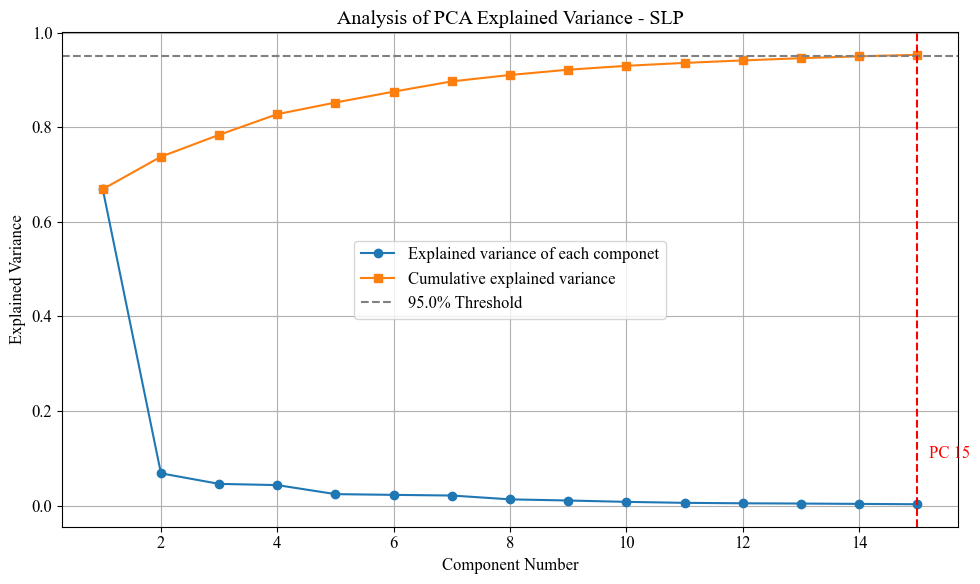

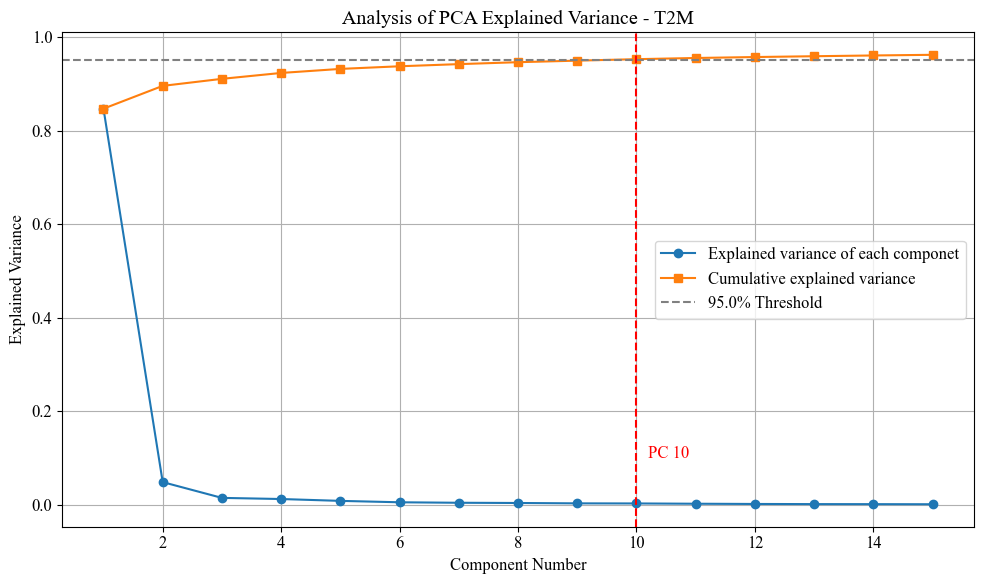

In [5]:
# Plot
fig_msl_ratio = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, n_components + 1), msl_ratio, 'o-', label='Explained variance of each componet')
plt.plot(np.arange(1, n_components + 1), msl_cumulative_ratio, 's-', label='Cumulative explained variance')

plt.axhline(y=threshold, color='gray', linestyle='--', label=f'{threshold*100}% Threshold')
plt.axvline(x=x_95_msl, color='red', linestyle='--')
plt.text(x_95_msl + 0.2, 0.1, f'PC {x_95_msl}', color='red')

plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.title(f"Analysis of PCA Explained Variance - SLP")
plt.grid(True)
plt.legend()
plt.tight_layout()
# fig_msl_ratio.savefig("./result_plots/1_PCA/pca_explained_variance_slp.png", dpi=500)

fig_t2m_ratio = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, n_components + 1), t2m_ratio, 'o-', label='Explained variance of each componet')
plt.plot(np.arange(1, n_components + 1), t2m_cumulative_ratio, 's-', label='Cumulative explained variance')

plt.axhline(y=threshold, color='gray', linestyle='--', label=f'{threshold*100}% Threshold')
plt.axvline(x=x_95_t2m, color='red', linestyle='--')
plt.text(x_95_t2m + 0.2, 0.1, f'PC {x_95_t2m}', color='red')

plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.title(f"Analysis of PCA Explained Variance - T2M")
plt.grid(True)
plt.legend()
plt.tight_layout()
# fig_t2m_ratio.savefig("./result_plots/1_PCA/pca_explained_variance_t2m.png", dpi=500)

plt.show()

## 1.2 PCA Principal Component Display

In [6]:
lon = ds_slp["longitude"].values
lat = ds_slp["latitude"].values
dim_info = np.array([16071,101,161]) # [ntime, nlat, nlon]

def pca_plot_k_mode(pca, k, lon, lat, name):
    variance = pca.explained_variance_ratio_
    
    for i in np.arange(k):
        mode_i = pca.components_[i].reshape(nlat, nlon)
        plt.figure(figsize=(8,5))
        plt.contourf(lon, lat, mode_i, cmap='coolwarm')
        plt.title(f"{name}: PCA MOD {i+1} ({variance[i]*100:.2f}% Var)")
        plt.colorbar()
        plt.tight_layout()
        # plt.savefig(f'./result_plots/1_PCA/{name}_pca_mode_{i+1}.png', dpi=500)
        plt.show()

### 1.2.1 SLP: PCA Modes

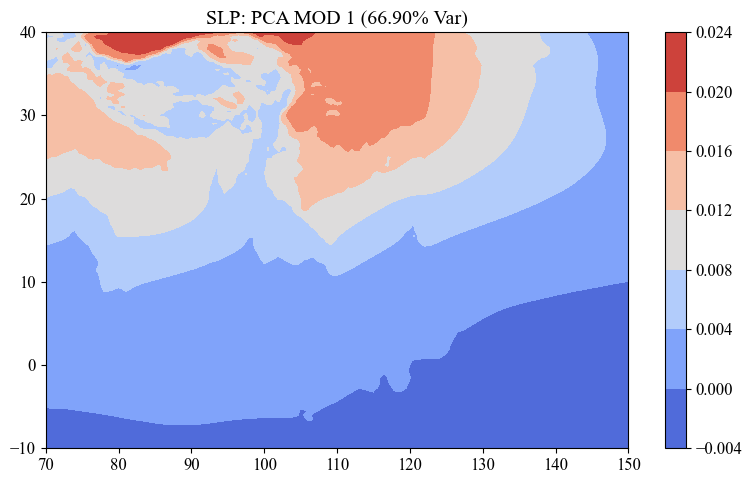

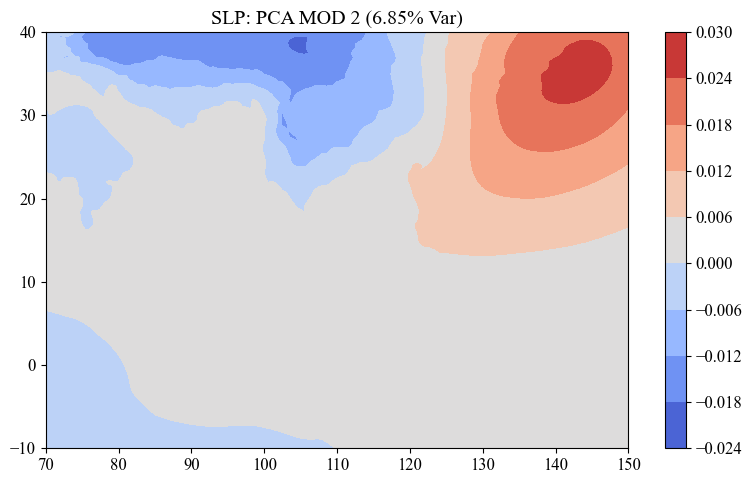

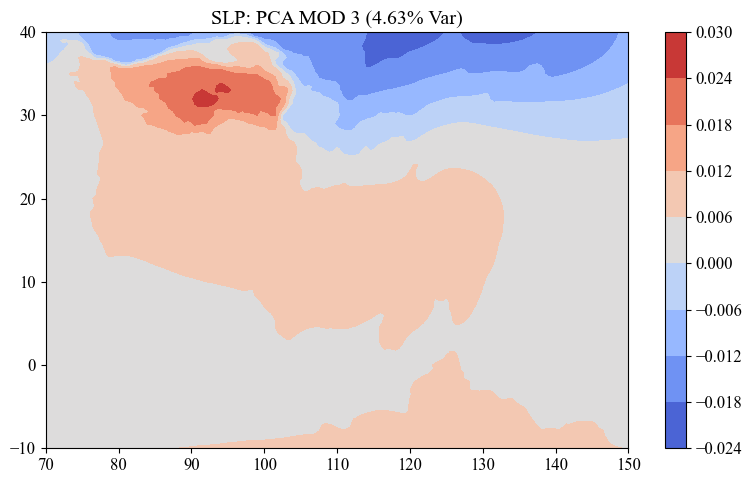

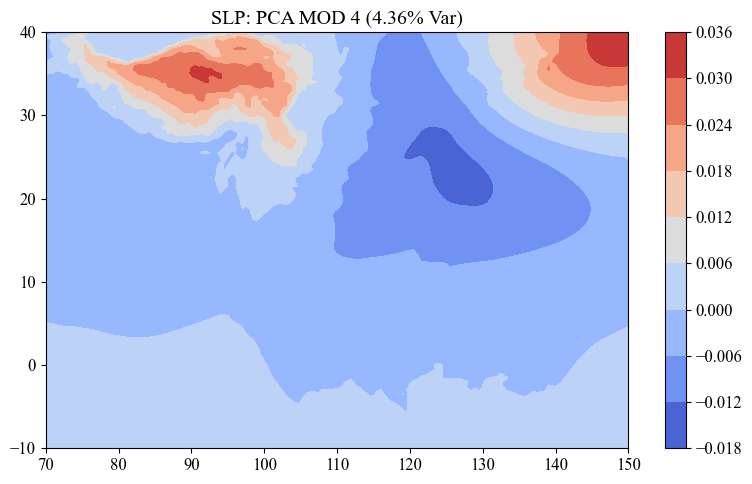

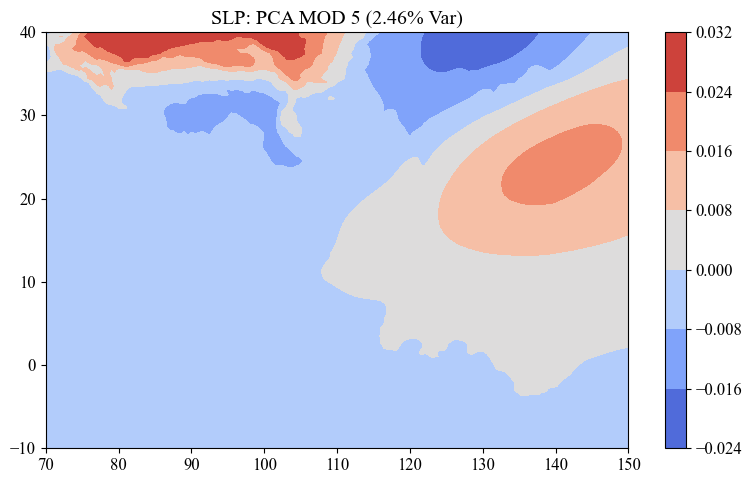

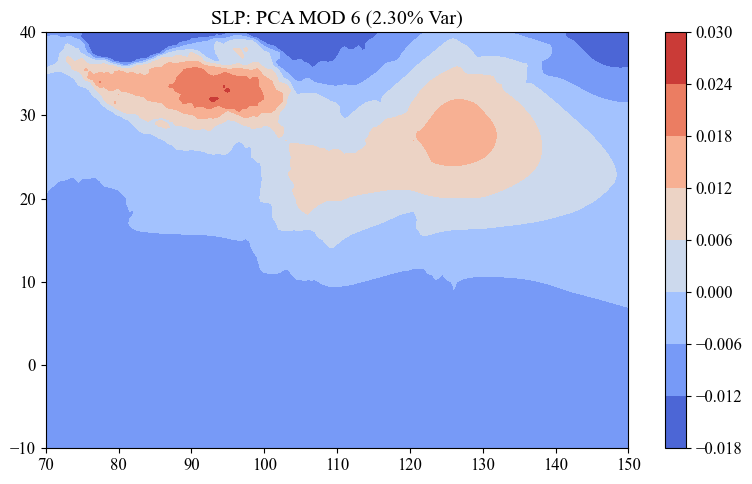

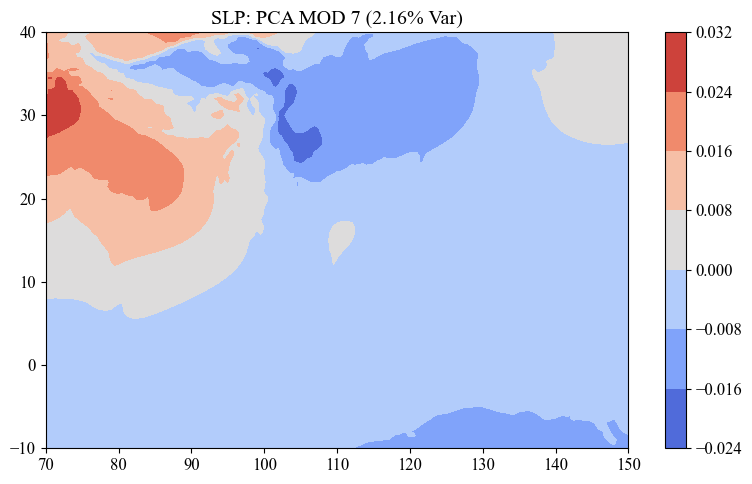

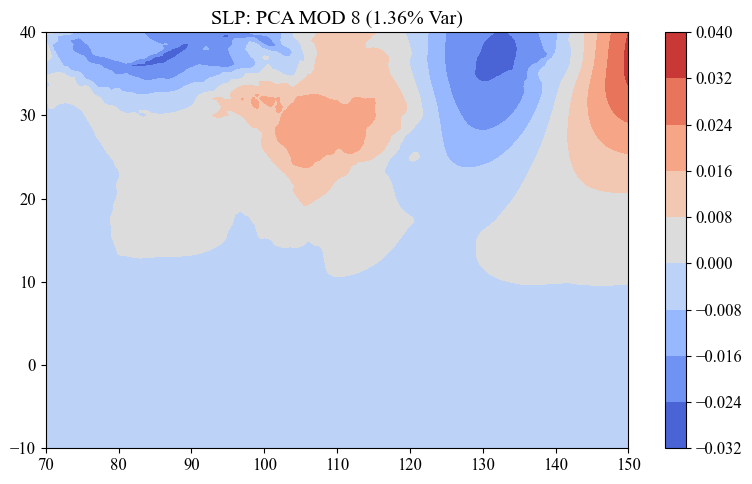

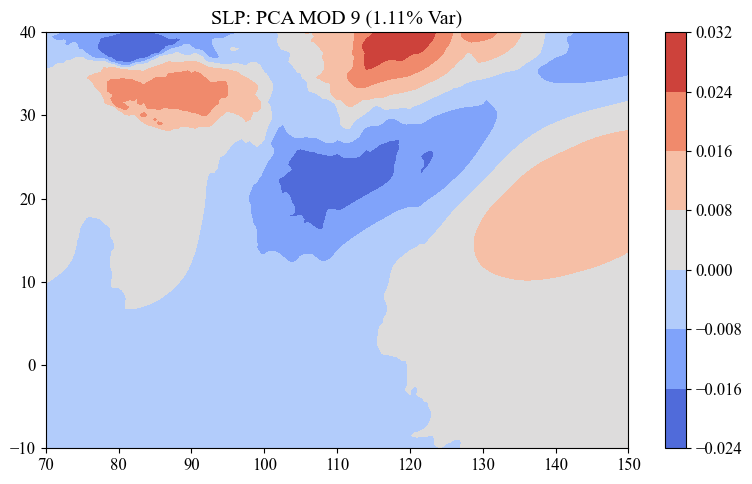

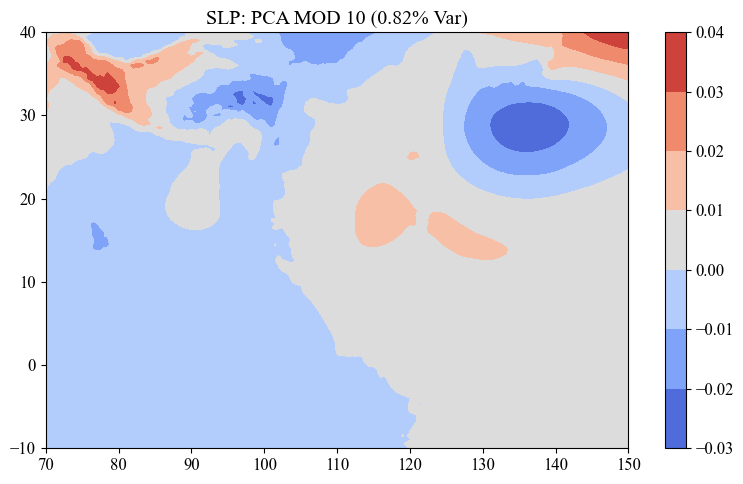

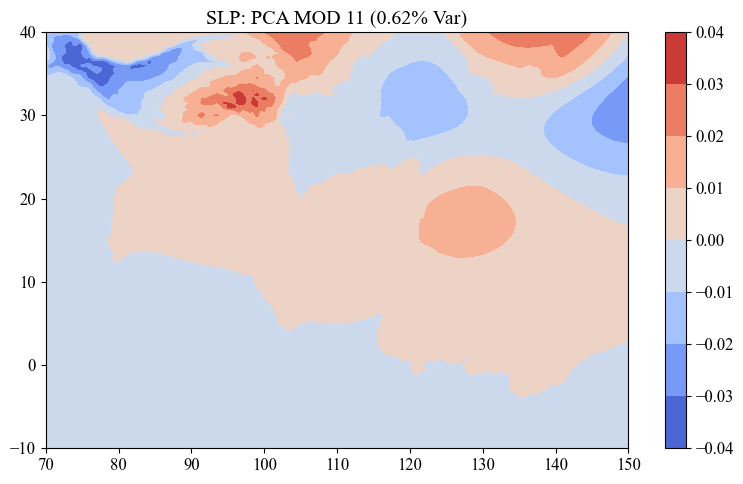

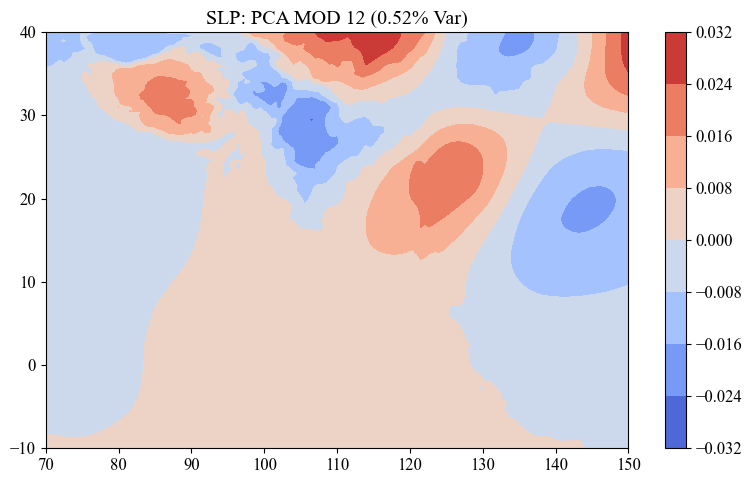

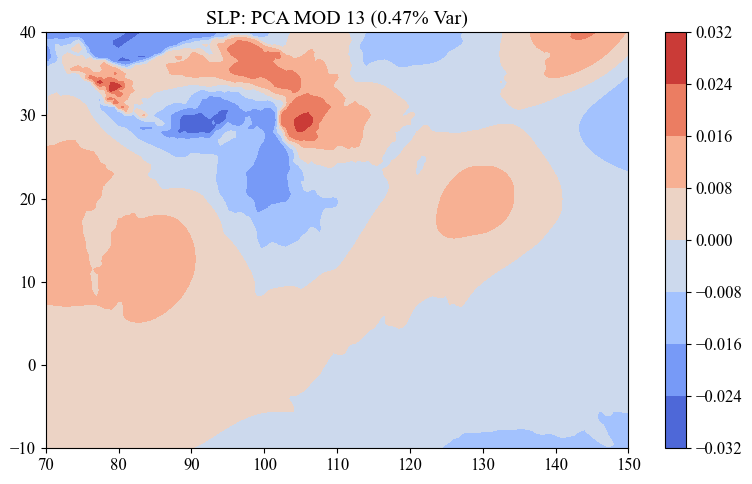

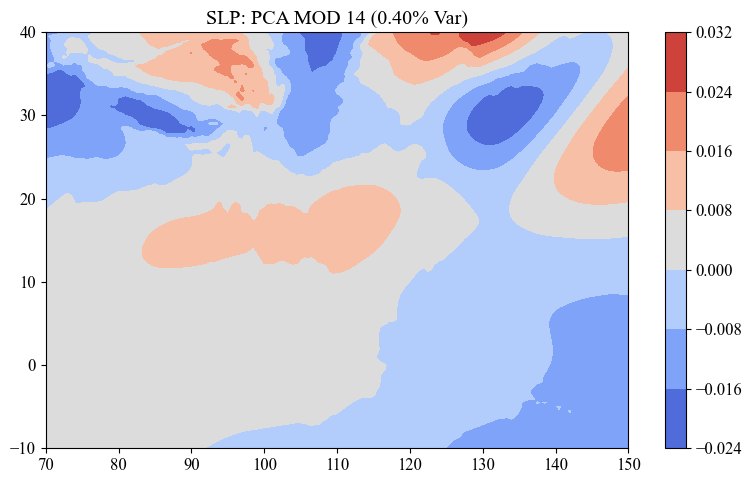

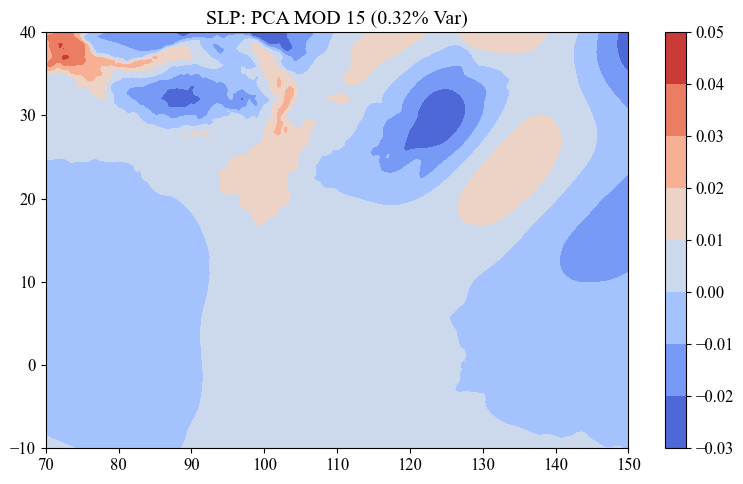

In [7]:
pca_plot_k_mode(pca1, n_components, lon, lat, 'SLP')

### 1.2.2 T2M: PCA Modes

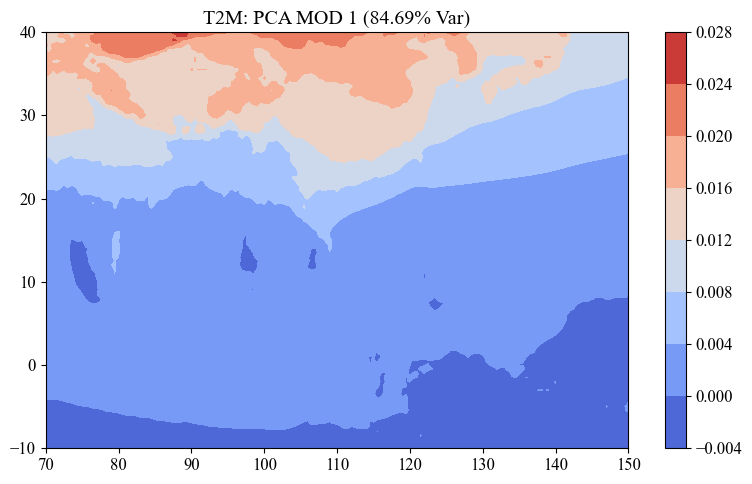

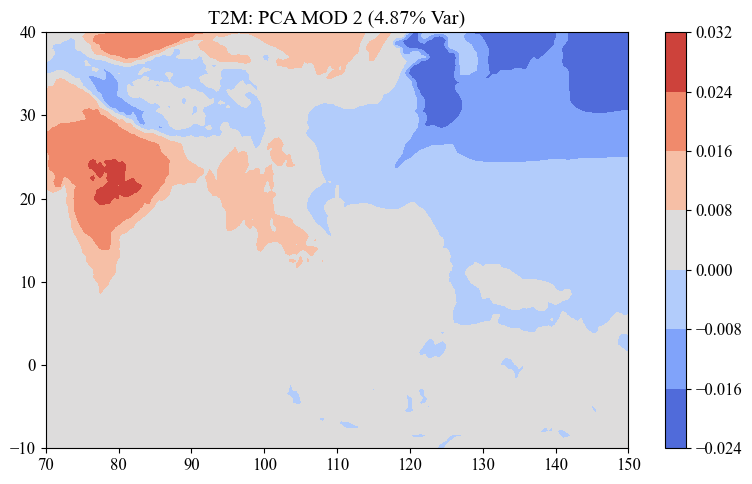

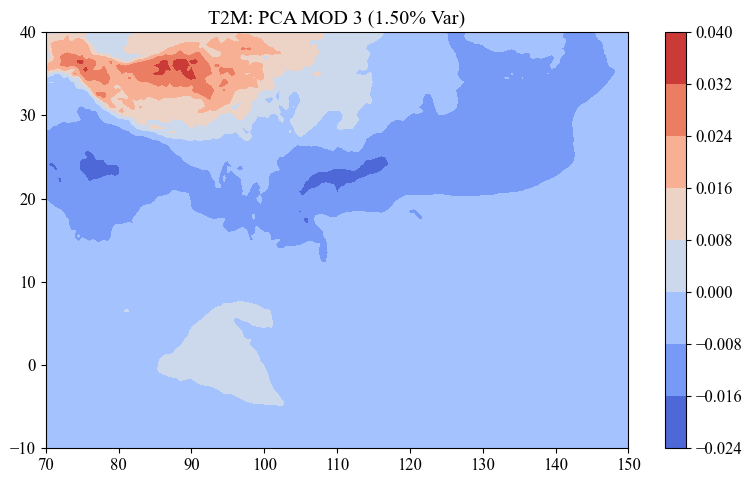

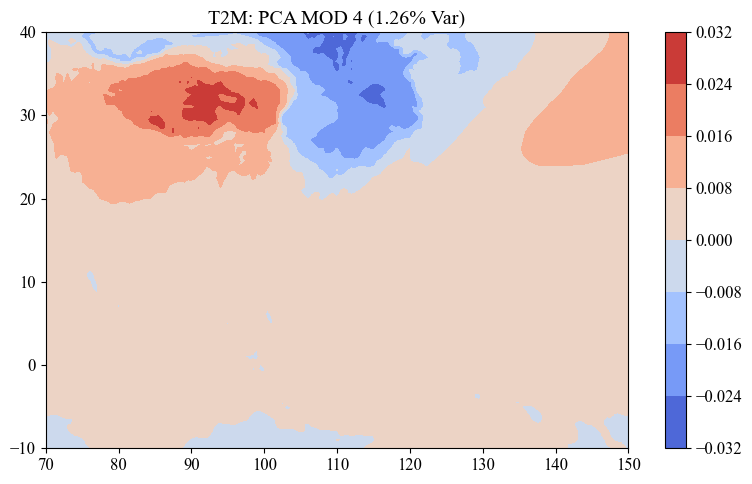

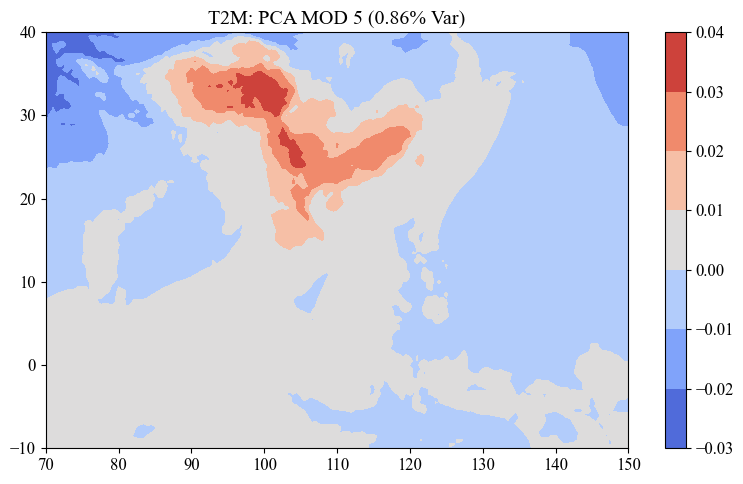

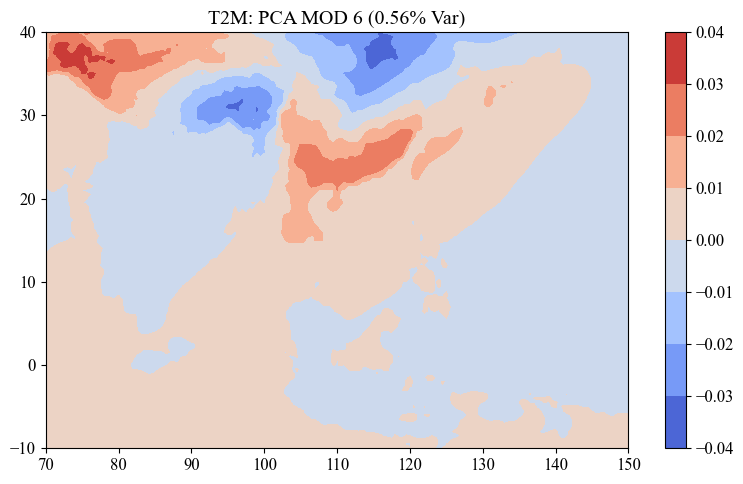

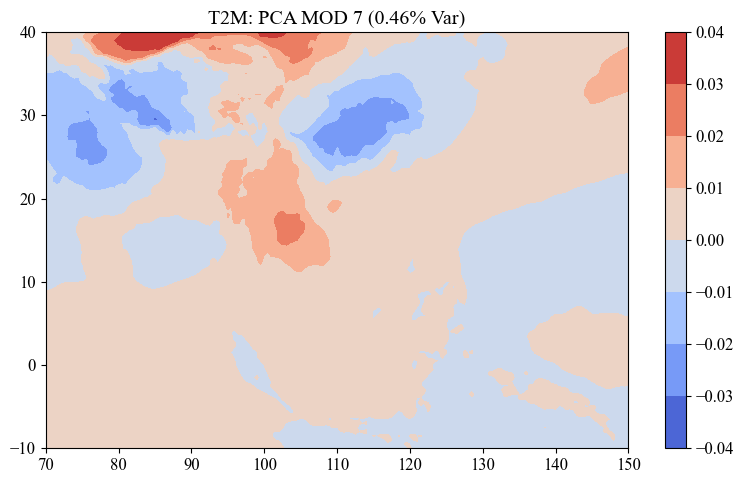

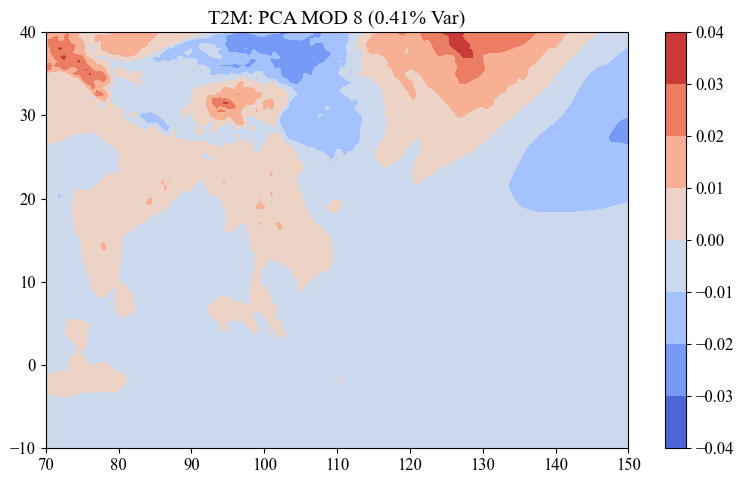

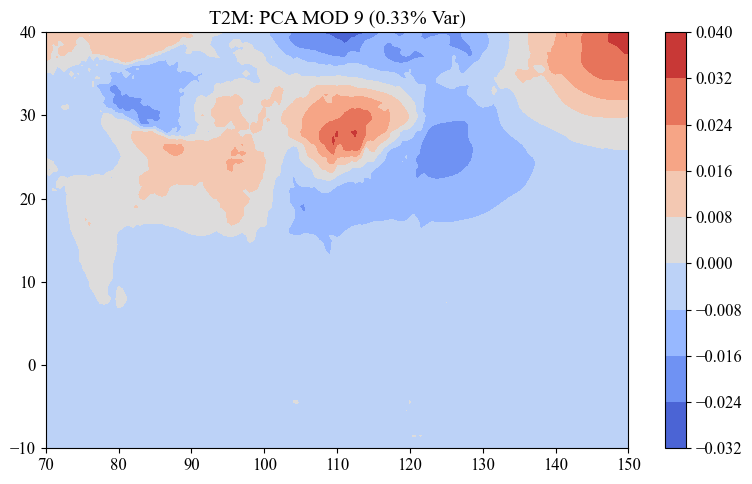

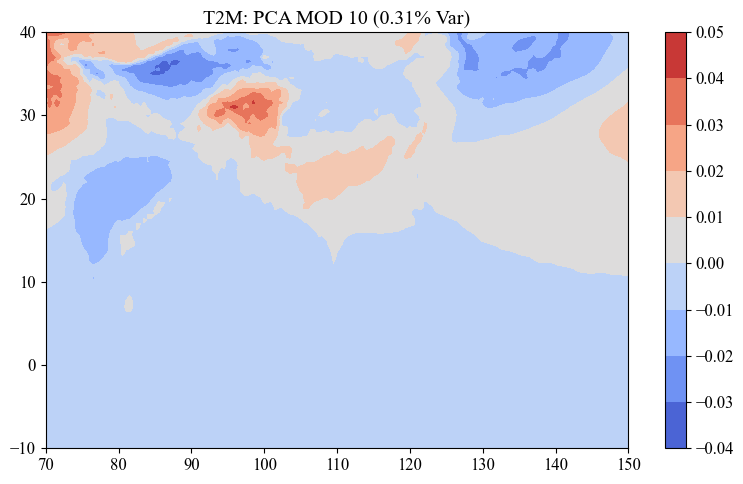

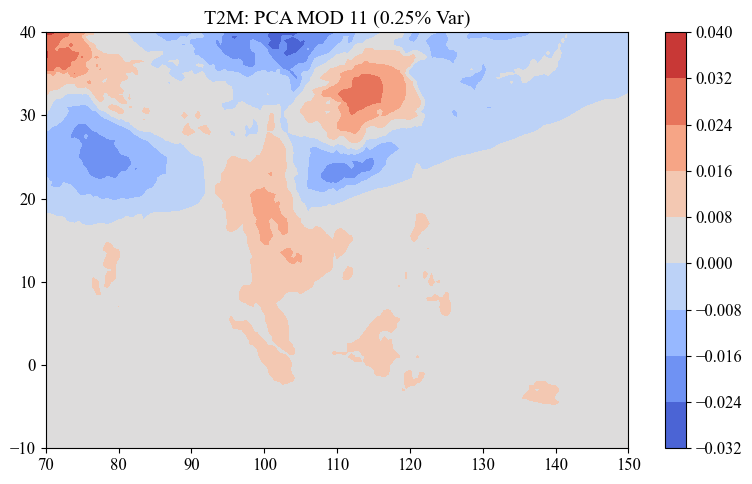

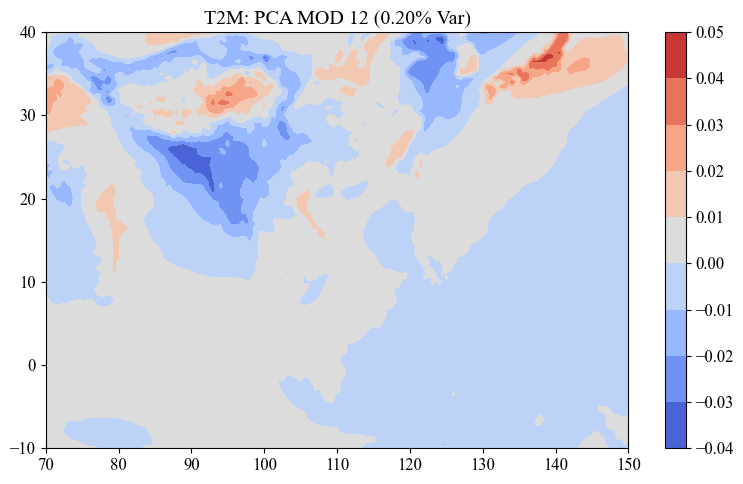

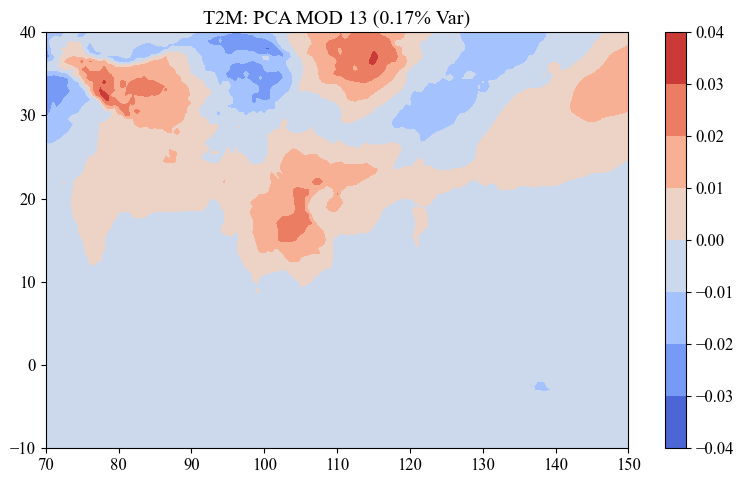

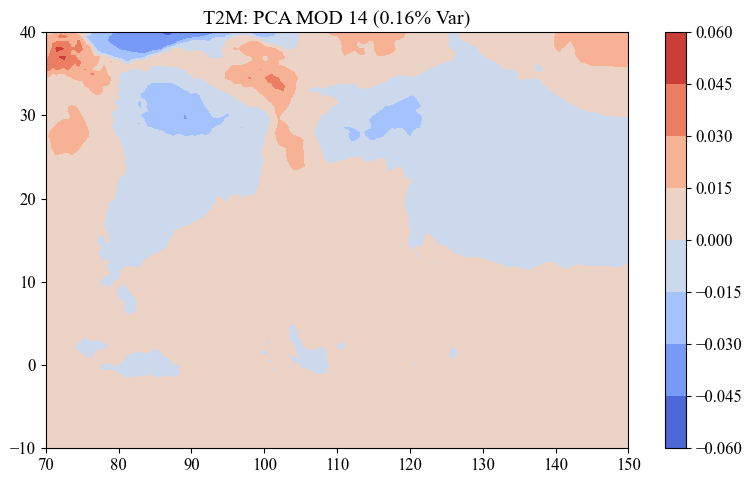

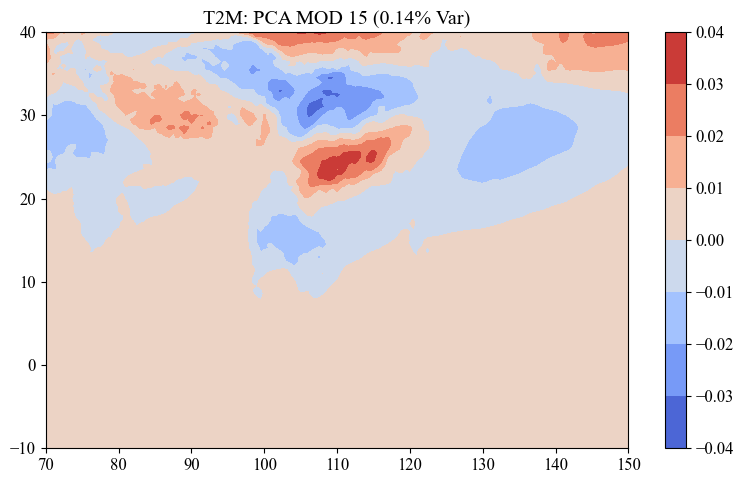

In [8]:
pca_plot_k_mode(pca2, n_components, lon, lat, 'T2M')

# 2. Dynamic Mode Decomposition (DMD)
In this task, we use DMD to analyze the dynamical system. To ensure reliable prediction using DMD, 80% of the data is used to construct the system model, while the remaining 20% is used for prediction evaluation.

In [14]:
def plot_eigs(eigs, name):
    
    plt.figure(figsize=(6,6))
    plt.plot(np.real(eigs), np.imag(eigs), 'o', color='blue', markersize=5, label='DMD Eigenvalues')
    
    circle = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)
    
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.title(f"{name}: DMD Eigenvalues on Complex Plane")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    # plt.savefig(f'./result_plots/2_DMD/{name}_DMD_eigenvalues.png', dpi=500)
    plt.show()

In [18]:
def dmd_plot_k_mode(dmd, pca, k, lon, lat, name):
    modes = dmd.modes.T
    eigs = dmd.eigs
    omega = np.log(eigs)
    freq = np.imag(omega) / (2 * np.pi)
    growth = np.real(omega)
    modes_physical = pca.inverse_transform(np.real(modes))
    
    for i in range(k):
        mode_map = modes_physical[i].reshape(lat.size, lon.size)
        plt.figure(figsize=(8,5))
        plt.contourf(lon, lat, mode_map, cmap='coolwarm')
        plt.title(f"{name}: DMD MODE {i+1} \nFreq: {freq[i]:.4f}  Growth: {growth[i]:.4f}")
        plt.colorbar()
        plt.tight_layout()
        # plt.savefig(f'./result_plots/2_DMD/{name}_dmd_mode_{i+1}.png', dpi=500)
        plt.show()

In [15]:
train_ratio = 0.8
split_idx = int(msl_pca.shape[0] * train_ratio)

msl_dmd_con, msl_x_dmdtest = msl_pca[:split_idx], msl_pca[split_idx:-1]
msl_y_dmdtest = msl_pca[split_idx+1:]

t2m_dmd_con, t2m_x_dmdtest = t2m_pca[:split_idx], t2m_pca[split_idx:-1]
t2m_y_dmdtest = t2m_pca[split_idx+1:]

## 2.1 DMD Mode Analysis

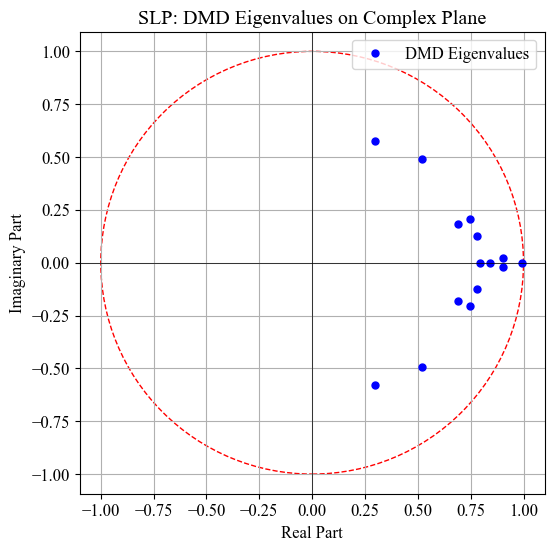

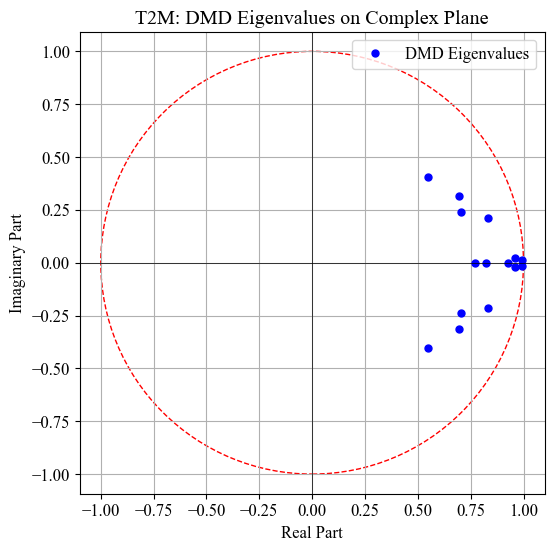

In [17]:
msl_dmd = msl_dmd_con.T
t2m_dmd = t2m_dmd_con.T

dmd1 = DMD(svd_rank=n_components, tlsq_rank=0, exact=True, opt=True, forward_backward=False)
dmd1.fit(msl_dmd)
msl_modes = dmd1.modes.T
plot_eigs(dmd1.eigs, 'SLP')

dmd2 = DMD(svd_rank=n_components, tlsq_rank=0, exact=True, opt=True, forward_backward=False)
dmd2.fit(t2m_dmd)
t2m_modes = dmd2.modes.T
plot_eigs(dmd2.eigs, 'T2M')

### 2.1.1 SLP: DMD Modes

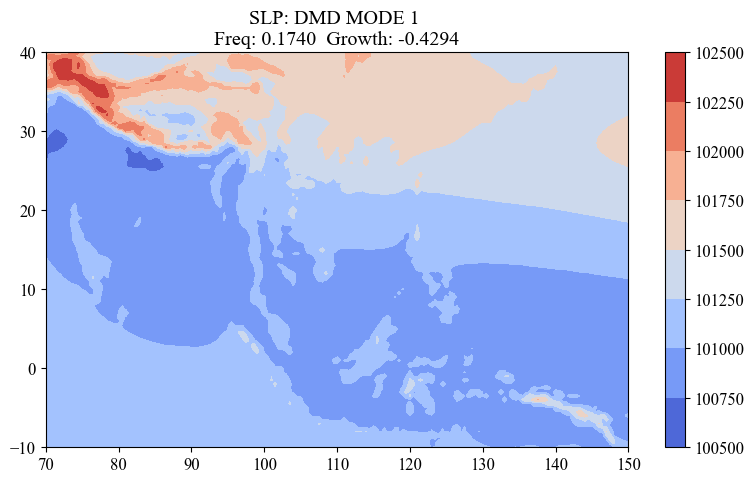

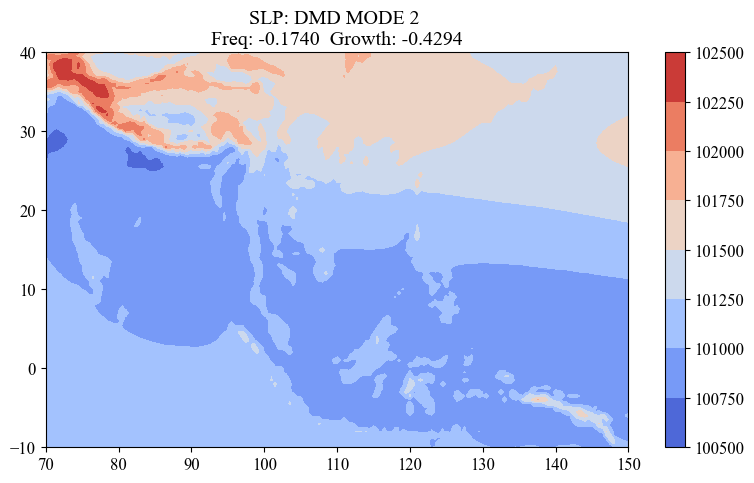

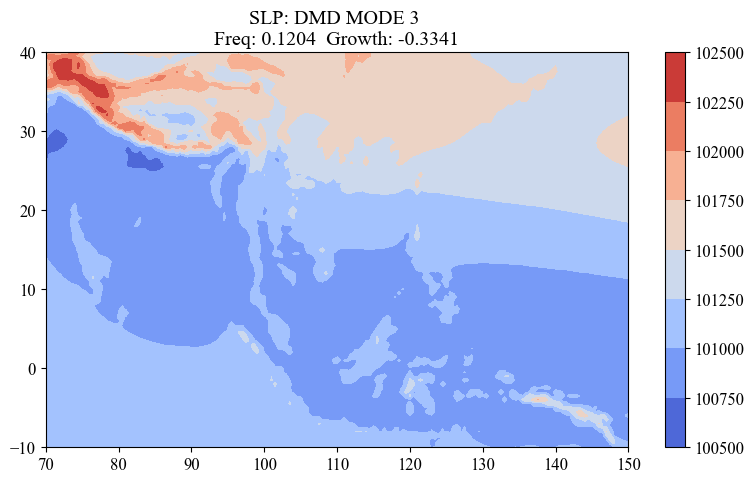

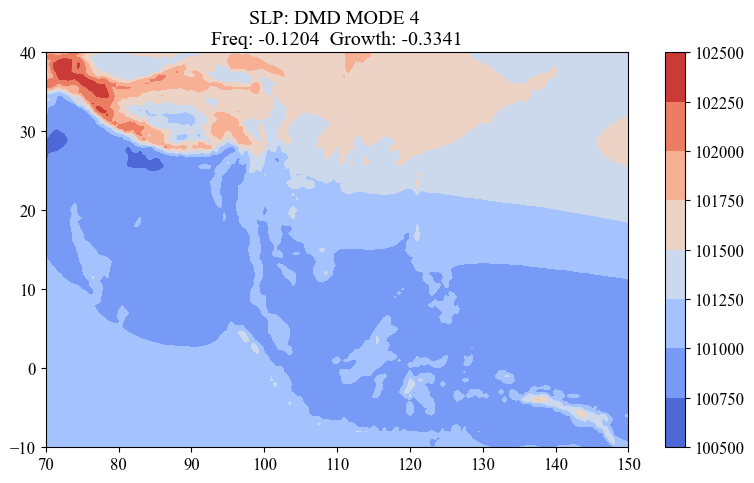

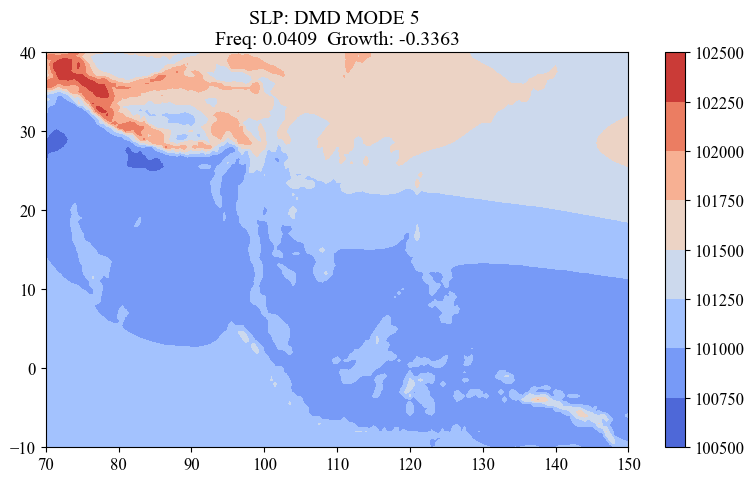

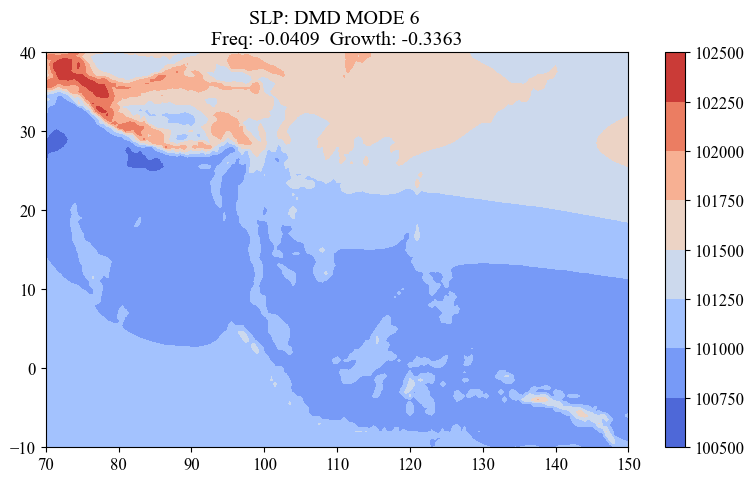

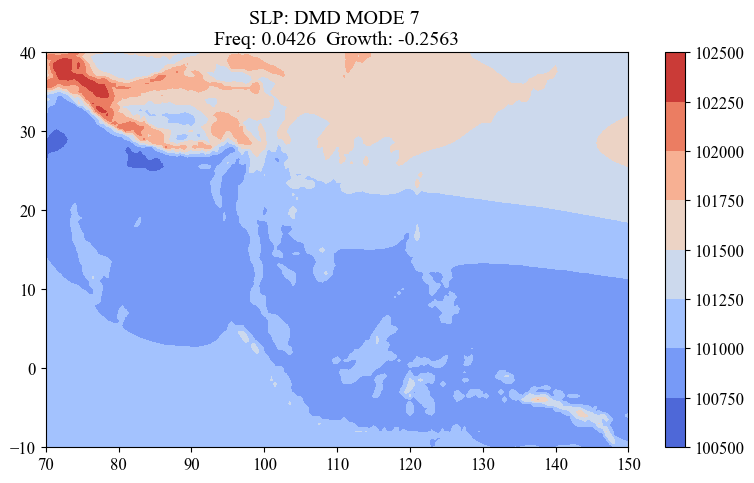

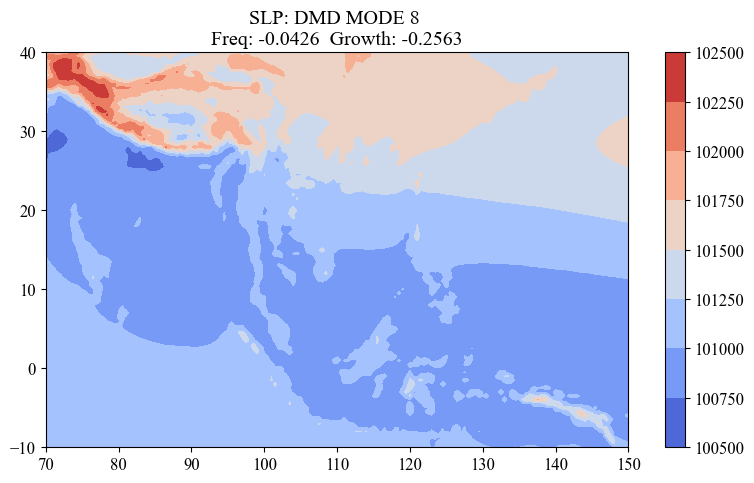

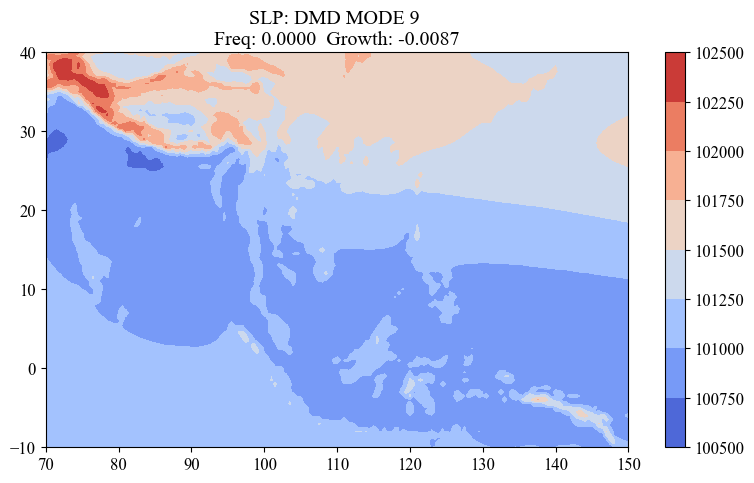

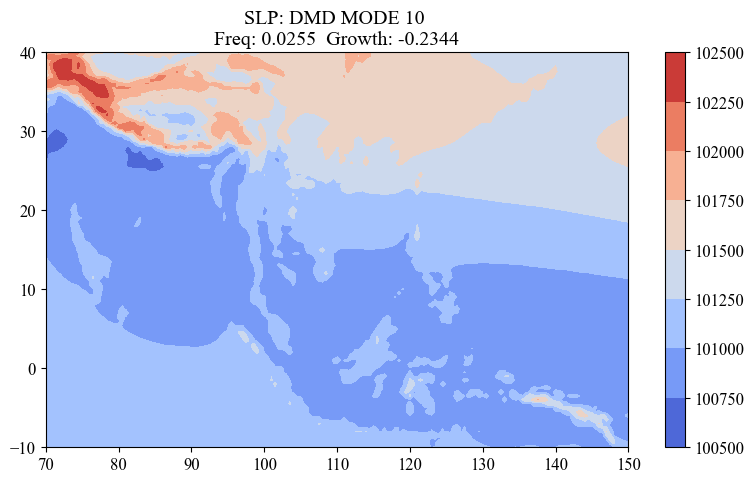

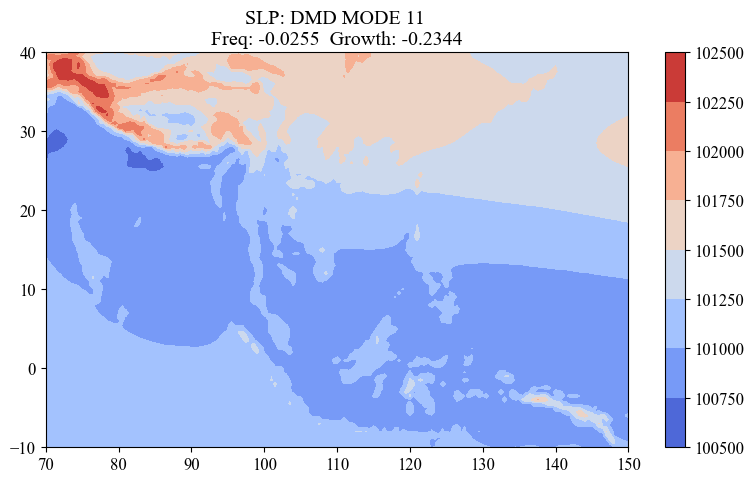

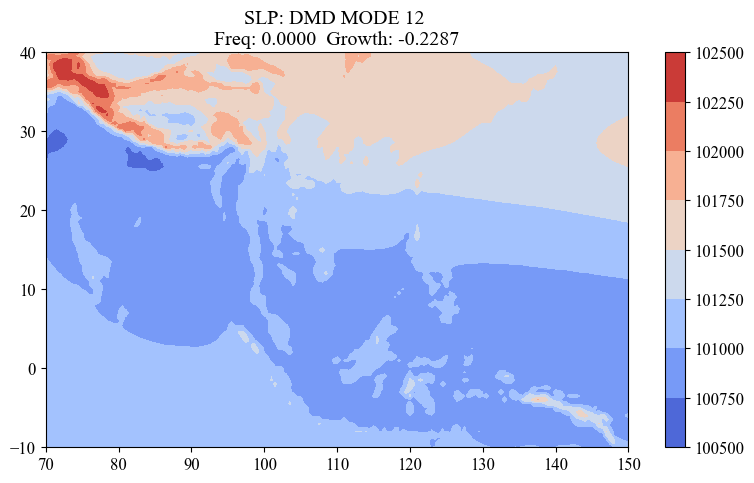

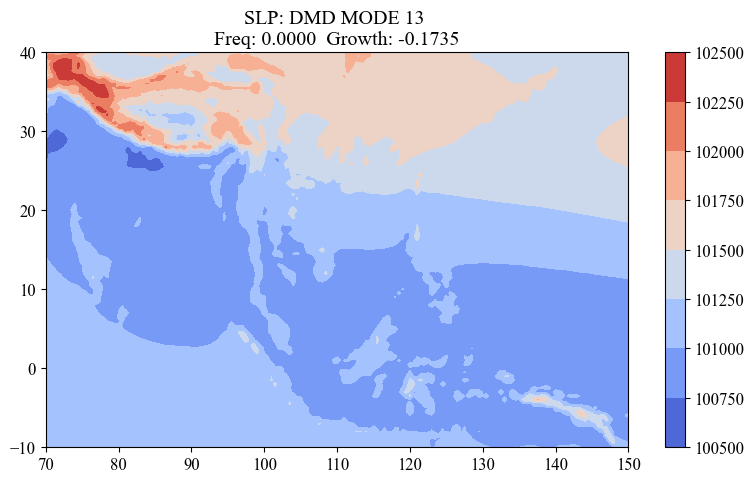

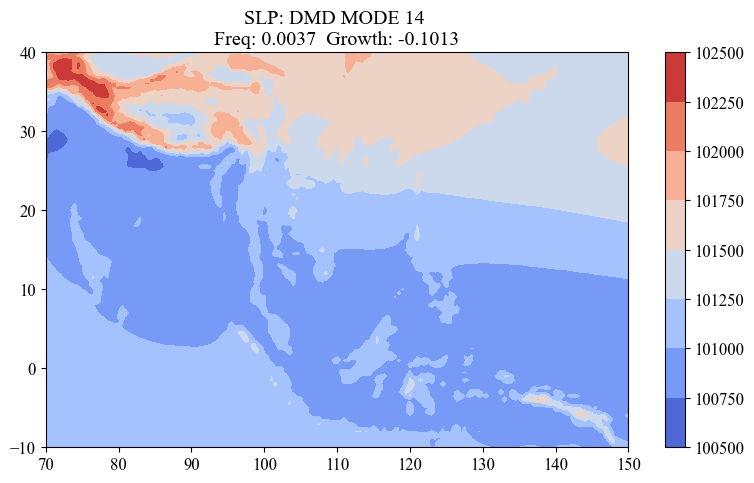

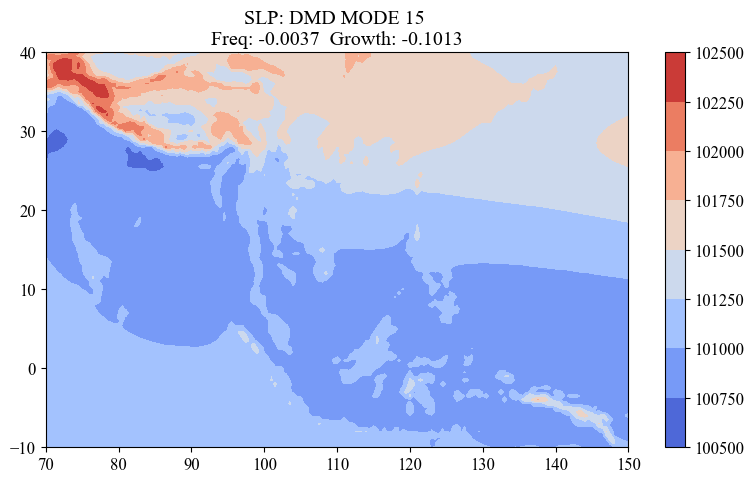

In [19]:
dmd_plot_k_mode(dmd1, pca1, n_components, lon, lat, 'SLP')

### 2.1.2 T2M: DMD Modes

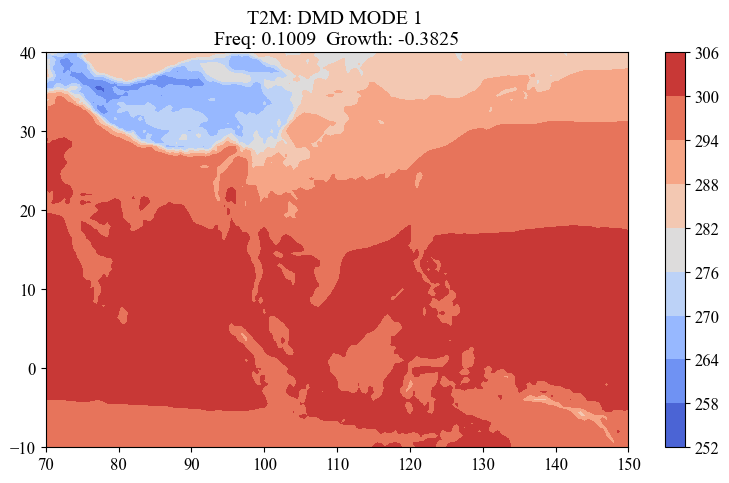

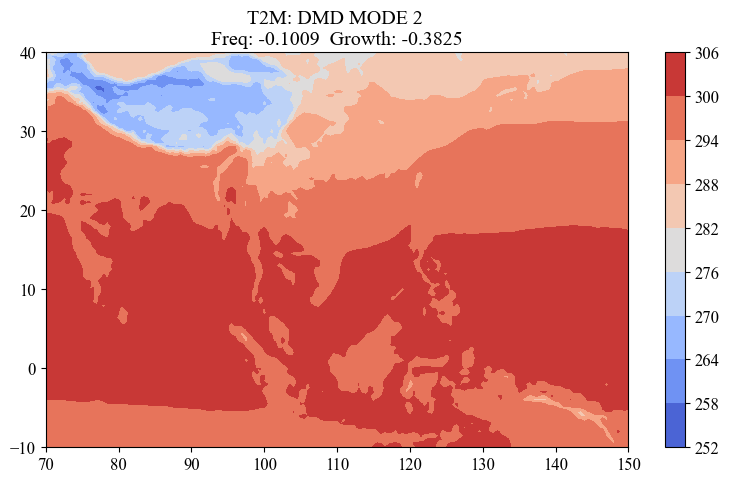

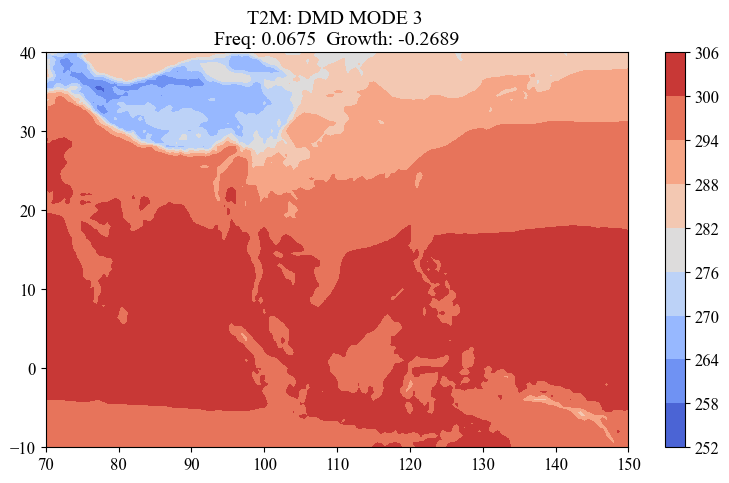

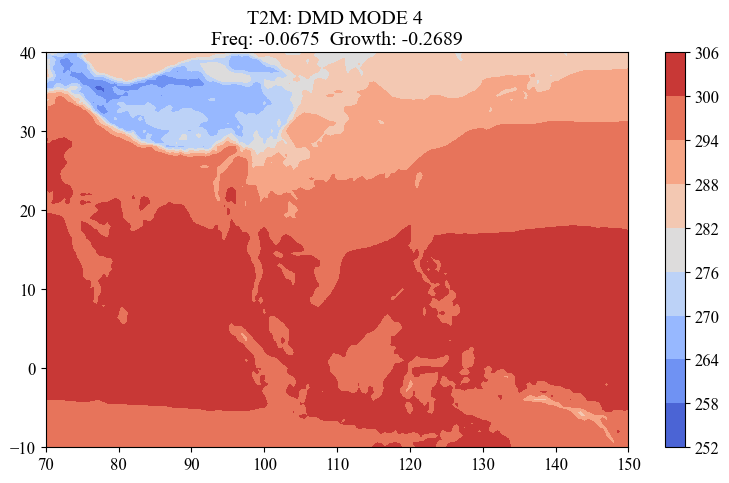

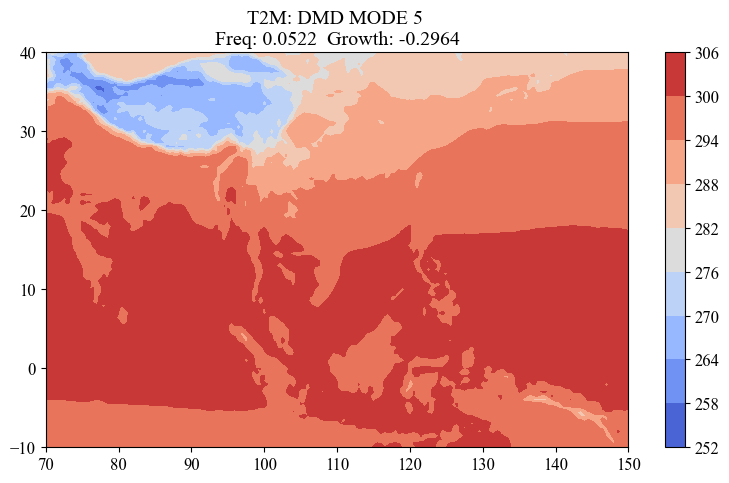

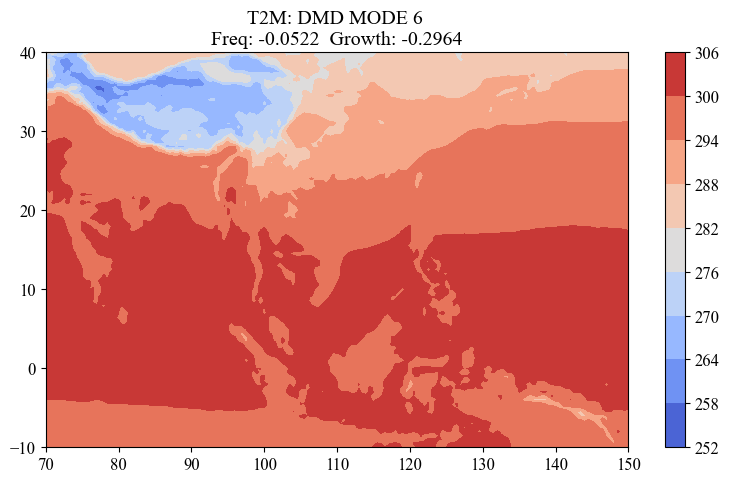

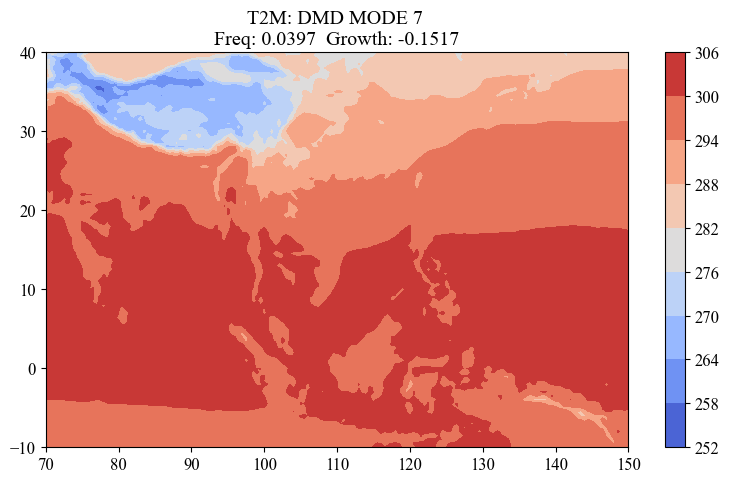

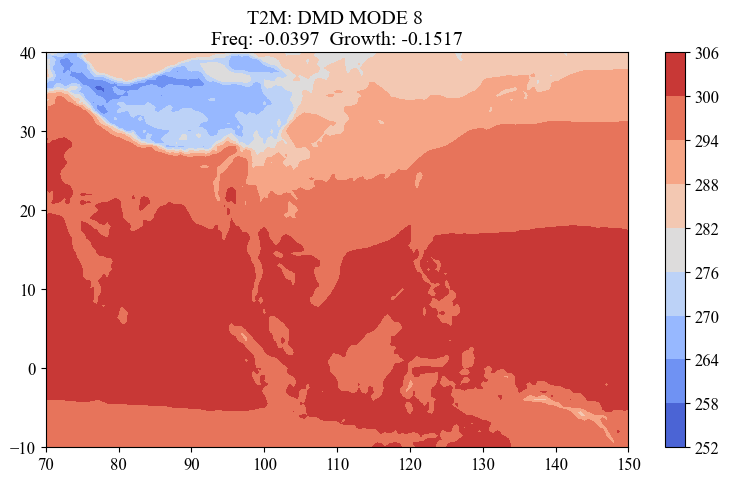

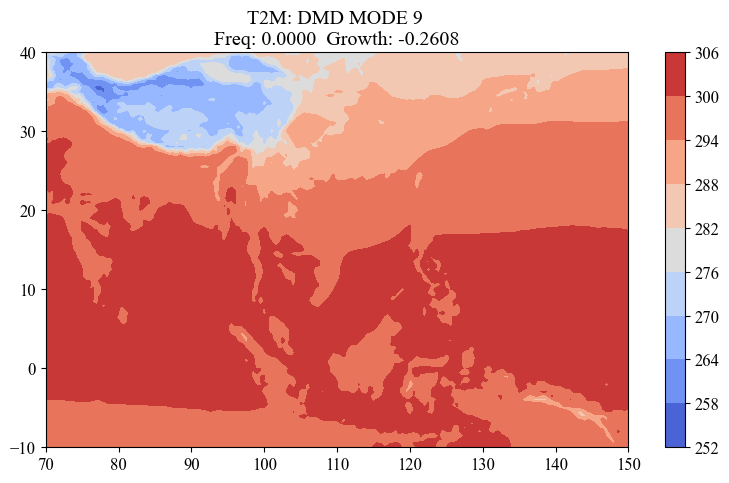

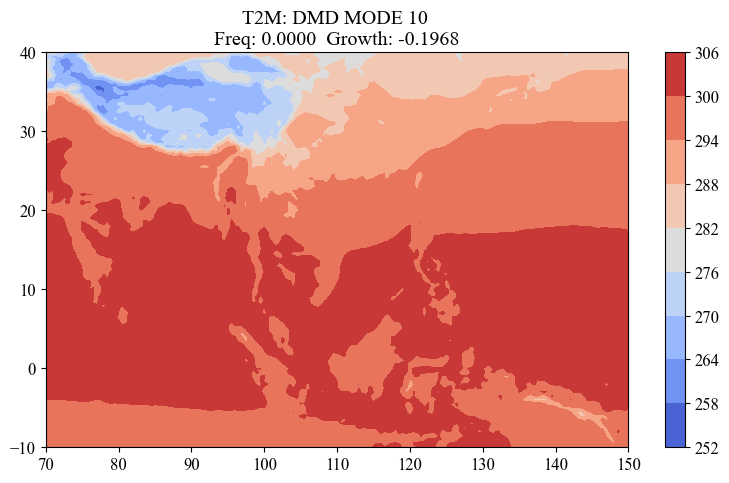

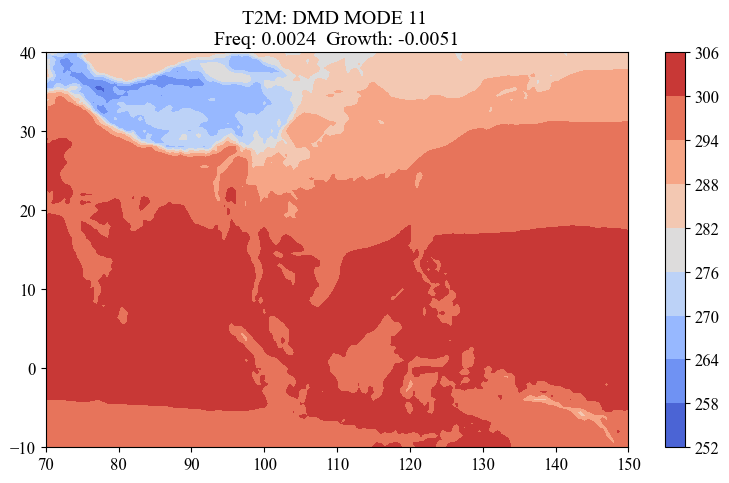

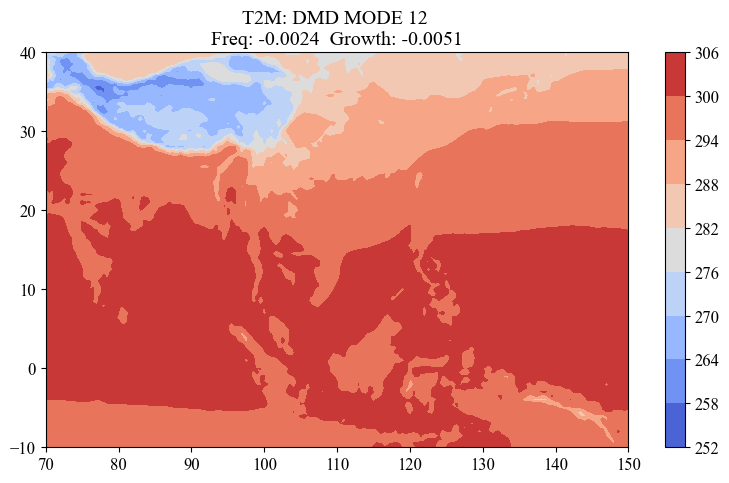

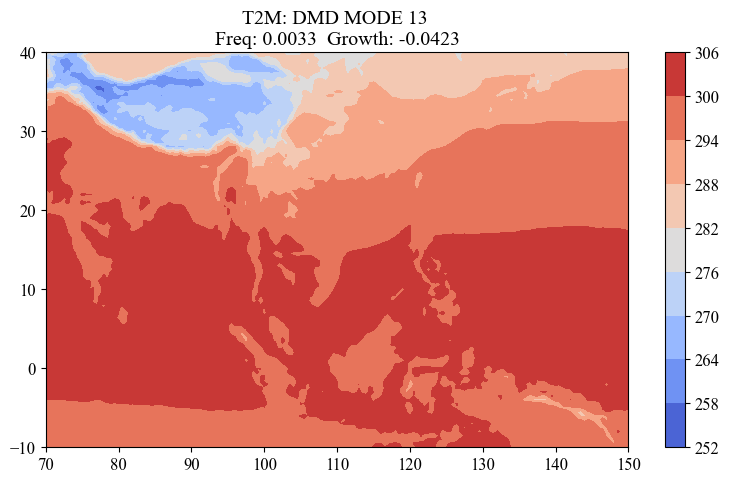

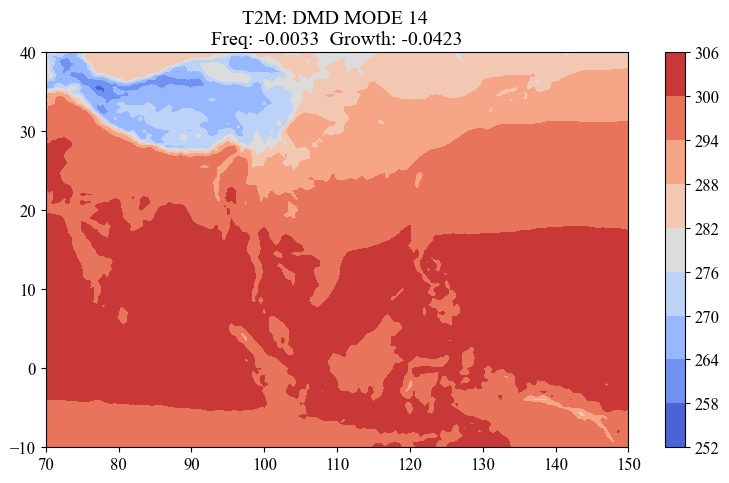

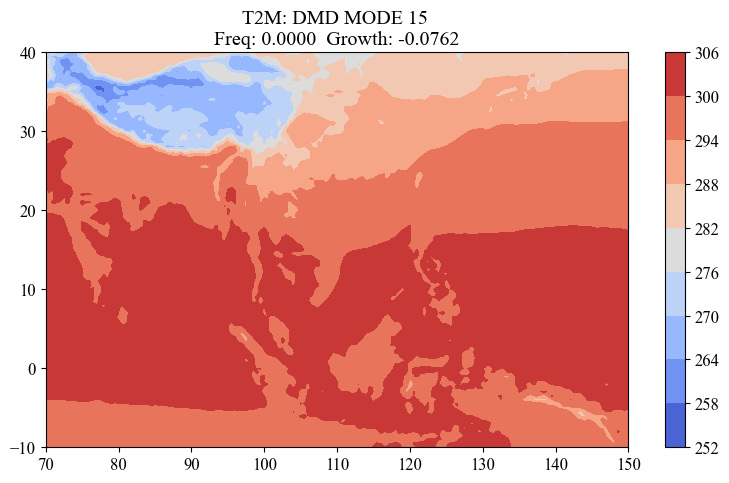

In [20]:
dmd_plot_k_mode(dmd2, pca2, n_components, lon, lat, 'T2M')

## 2.2 System Reconstruction

In [15]:
msl_dmd_recon = dmd1.reconstructed_data
t2m_dmd_recon = dmd2.reconstructed_data

## 2.3 One-step Ahead Prediction

In [37]:
def eval_metrics_calculation(y_pred, y_real, number_mode, name):
    rmse = np.sqrt(np.mean((y_real-y_pred)**2, axis=0))
    mae = np.mean(np.abs(y_real-y_pred), axis=0)
    r2 = 1 - np.sum((y_real-y_pred)**2, axis=0) / np.sum((y_real-np.mean(y_real, axis=0))**2, axis=0)
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)
    mean_r2 = np.mean(r2)
    
    print(f"Mean_rmse:{mean_rmse}\nMean_mae:{mean_mae}\nMean_r2:{mean_r2}")
    print("---------- PCA MODES PREDICTION DISPALY ----------")
    for i in range(number_mode):
        plt.figure(figsize=(10,6))
        plt.plot(y_real[:, i], label=f'True PC{i+1}')
        plt.plot(y_pred[:, i], label=f'Predicted PC{i+1}')
        plt.title(f'{name}: Predicted vs True Principal Component {i+1}\n(RMSE:{rmse[i]:.2f},  MAE:{mae[i]:.2f},  R2:{r2[i]:.2f})')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        # plt.savefig(f'./result_plots/2_DMD/{name}_dmd1spred_mode_{i+1}.png', dpi=500)
        # plt.savefig(f'./result_plots/3_LSTM/{name}_lstmpred_mode_{i+1}.png', dpi=500)
        plt.show()
        
    return rmse, mae, r2

### 2.3.1 SLP: DMD One-step Prediction

Mean_rmse:4742.1591796875
Mean_mae:3700.292236328125
Mean_r2:0.632961630821228
---------- PCA MODES PREDICTION DISPALY ----------


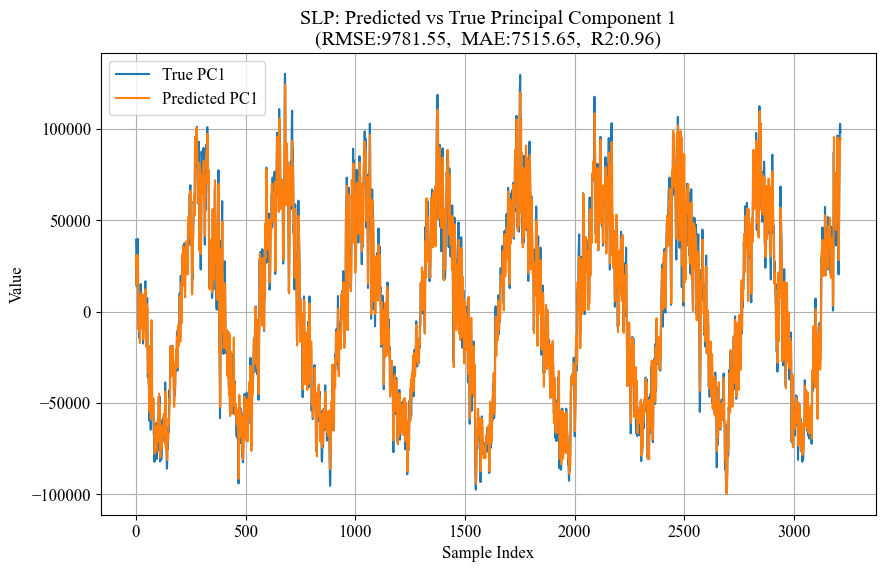

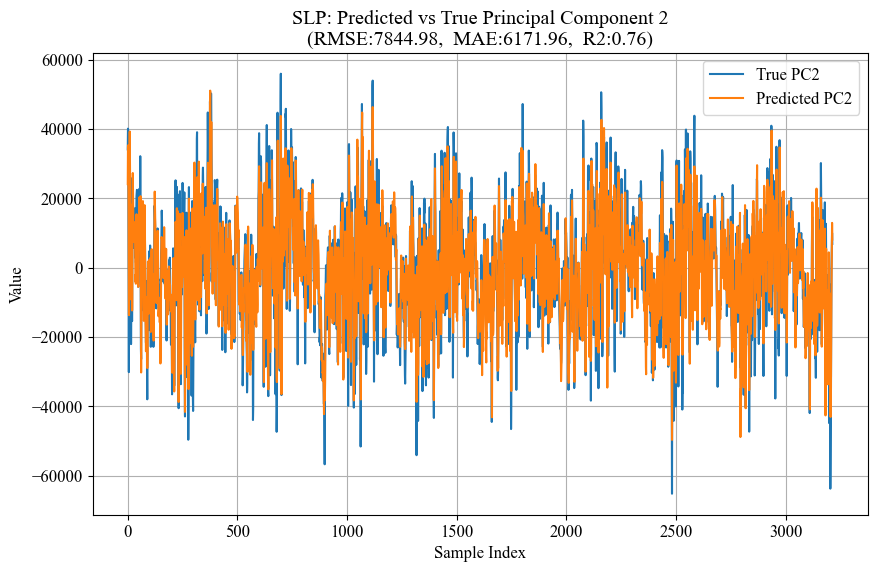

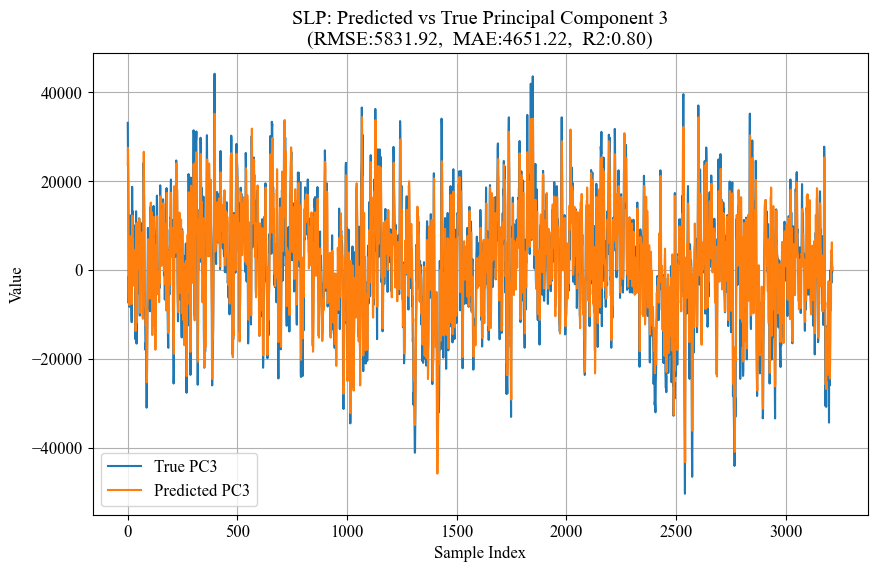

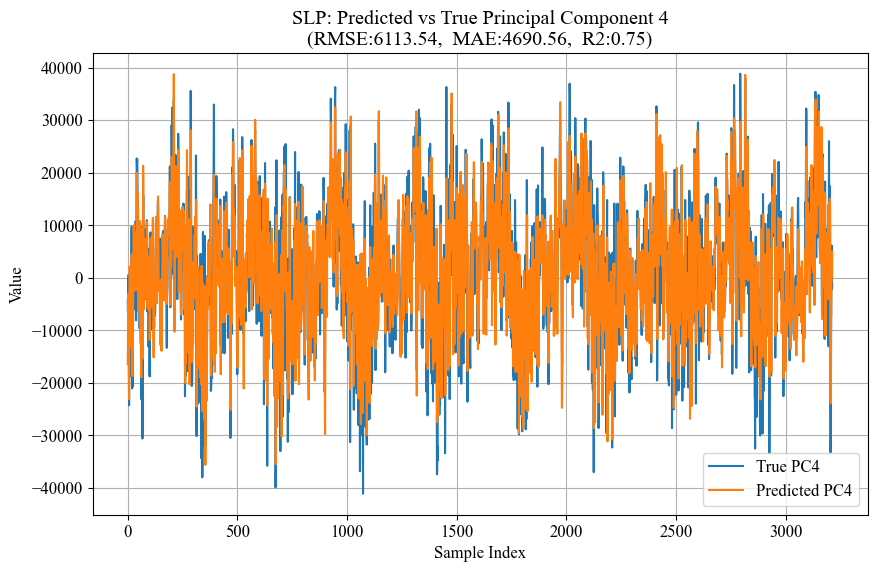

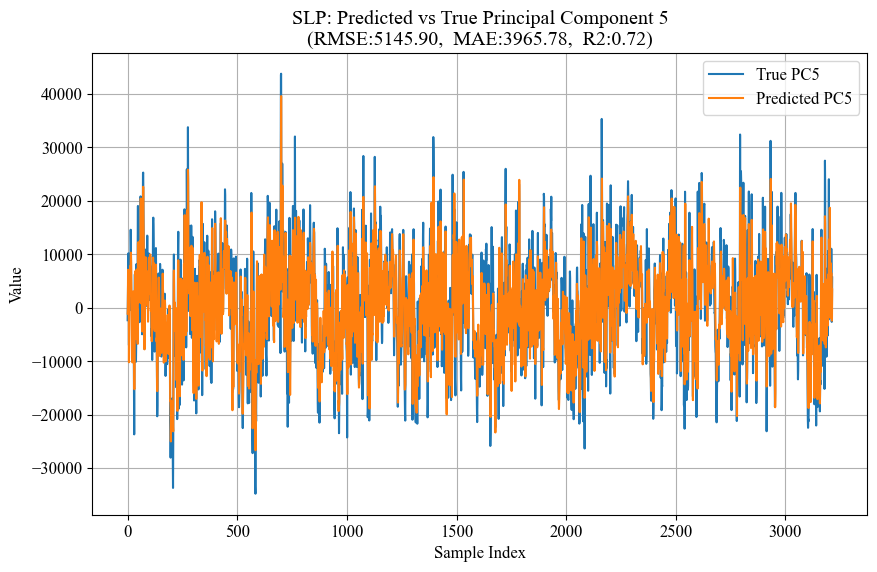

In [26]:
msl_y_dmdpred = np.real(dmd1.predict(msl_x_dmdtest.T).T)
msl_dmd_rmse, msl_dmd_mae, msl_dmd_r2 = eval_metrics_calculation(msl_y_dmdpred, msl_y_dmdtest, 5, 'SLP')

### 2.3.2 T2M: DMD One-step Prediction

Mean_rmse:21.50496482849121
Mean_mae:16.769786834716797
Mean_r2:0.7107639908790588
---------- PCA MODES PREDICTION DISPALY ----------


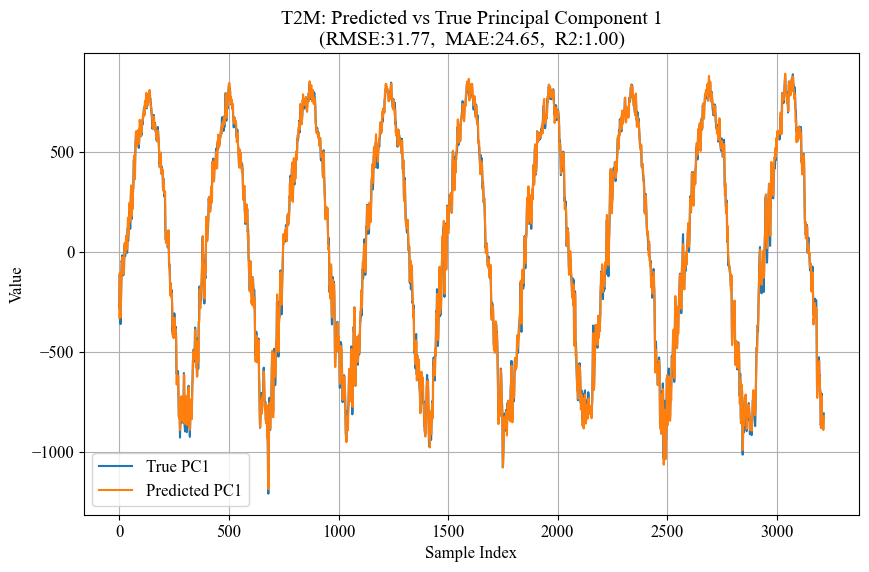

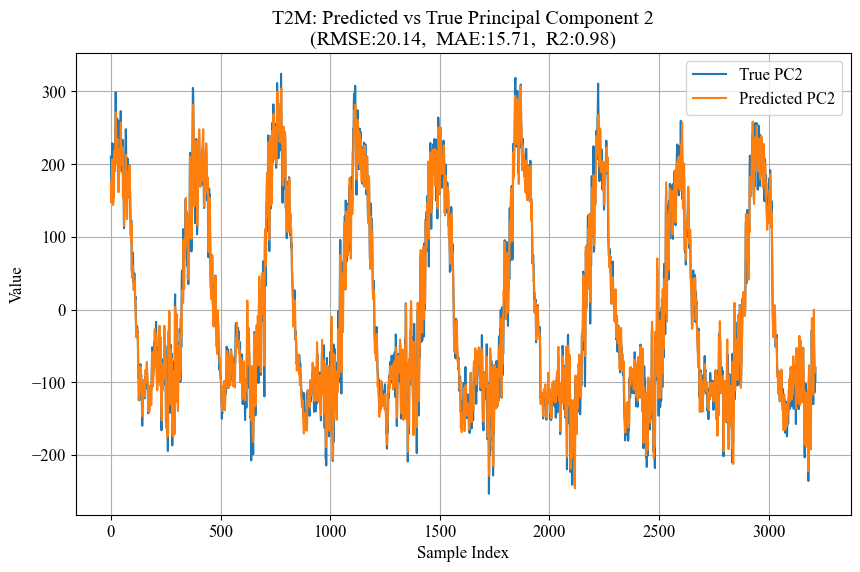

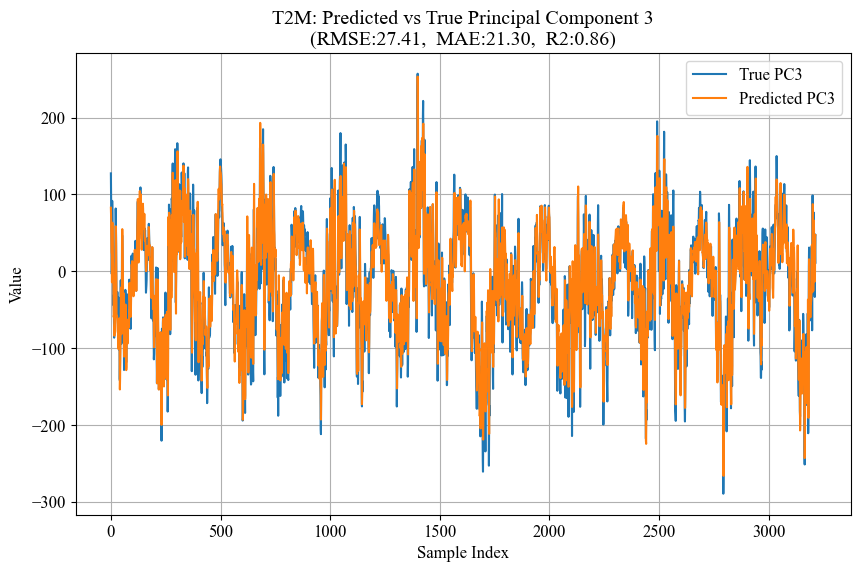

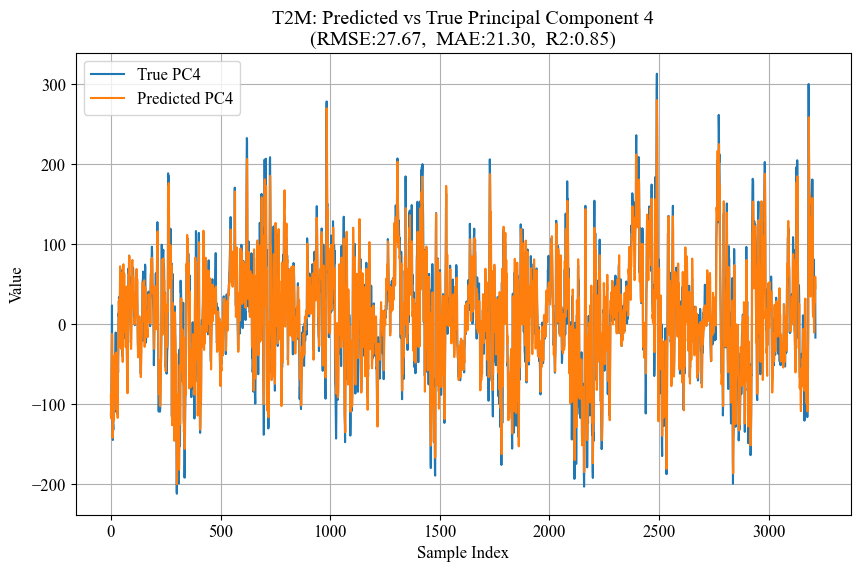

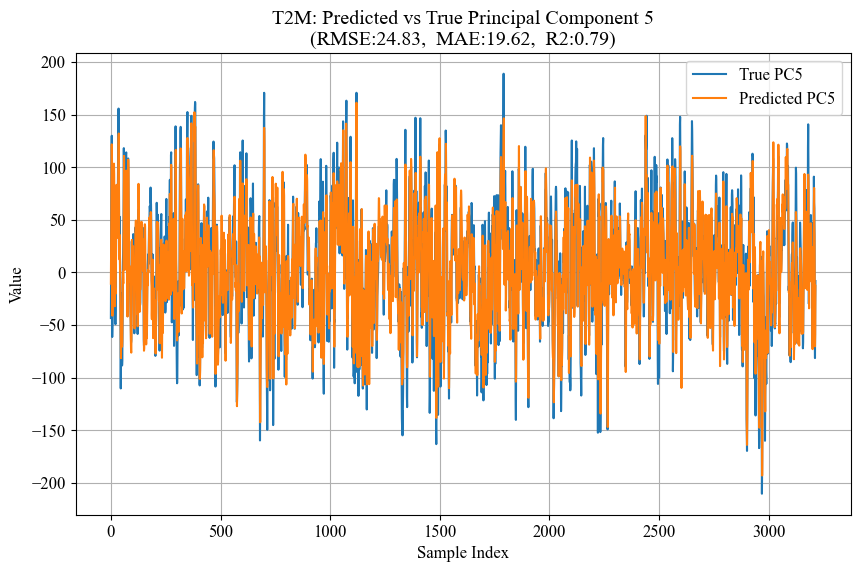

In [25]:
t2m_y_dmdpred = np.real(dmd2.predict(t2m_x_dmdtest.T).T)
t2m_dmd_rmse, t2m_dmd_mae, t2m_dmd_r2 = eval_metrics_calculation(t2m_y_dmdpred, t2m_y_dmdtest, 5, 'T2M')

# 3 LSTM Prediction
80% of the data is used as the training set, and 20% as the test set. Ten consecutive states are used to predict the next state.

In [34]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

def plot_train_process(history, name):
    # Loss
    fig_loss = plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name}: Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # fig_loss.savefig(f"./result_plots/3_LSTM/{name}_train_loss.png", dpi=500)
    
    # MAE
    fig_mae = plt.figure(figsize=(6, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{name}: Train vs Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # fig_loss.savefig(f"./result_plots/3_LSTM/{name}_train_mae.png", dpi=500)

    # MSE
    fig_mse = plt.figure(figsize=(6, 4))
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title(f'{name}: Train vs Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # fig_loss.savefig(f"./result_plots/3_LSTM/{name}_train_mse.png", dpi=500)
    
    plt.show()

## 3.1 SLP：LSTM Prediction 

### Data Normalization and Splitting

In [28]:
n_steps = 10

scaler_msl = StandardScaler()
msl_pca_scaled = scaler_msl.fit_transform(msl_pca)
msl_x_seq, msl_y_seq = create_sequences(msl_pca_scaled, n_steps)

train_ratio = 0.8
split_idx = int(len(msl_x_seq) * train_ratio)
msl_x_train, msl_x_test = msl_x_seq[:split_idx], msl_x_seq[split_idx:]
msl_y_train, msl_y_test = msl_y_seq[:split_idx], msl_y_seq[split_idx:]

### Model Construction

In [29]:
msl_model = Sequential()
msl_model.add(LSTM(128, return_sequences=False, input_shape=(msl_x_train.shape[1], msl_x_train.shape[2])))
msl_model.add(Dropout(0.2))
msl_model.add(Dense(msl_x_train.shape[2]))

msl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

### Train

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

msl_history = msl_model.fit(
    msl_x_train, msl_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(msl_x_test, msl_y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
402/402 [==============================] - 6s 9ms/step - loss: 0.5414 - mae: 0.5652 - mse: 0.5414 - val_loss: 0.3138 - val_mae: 0.4267 - val_mse: 0.3138
Epoch 2/1000
402/402 [==============================] - 3s 8ms/step - loss: 0.3157 - mae: 0.4295 - mse: 0.3157 - val_loss: 0.2537 - val_mae: 0.3803 - val_mse: 0.2537
Epoch 3/1000
402/402 [==============================] - 4s 9ms/step - loss: 0.2826 - mae: 0.4055 - mse: 0.2826 - val_loss: 0.2417 - val_mae: 0.3709 - val_mse: 0.2417
Epoch 4/1000
402/402 [==============================] - 3s 8ms/step - loss: 0.2720 - mae: 0.3971 - mse: 0.2720 - val_loss: 0.2345 - val_mae: 0.3654 - val_mse: 0.2345
Epoch 5/1000
402/402 [==============================] - 3s 8ms/step - loss: 0.2639 - mae: 0.3910 - mse: 0.2639 - val_loss: 0.2326 - val_mae: 0.3636 - val_mse: 0.2326
Epoch 6/1000
402/402 [==============================] - 3s 8ms/step - loss: 0.2583 - mae: 0.3870 - mse: 0.2583 - val_loss: 0.2272 - val_mae: 0.3590 - val_mse: 0.2272
Epoc

### Evaluation

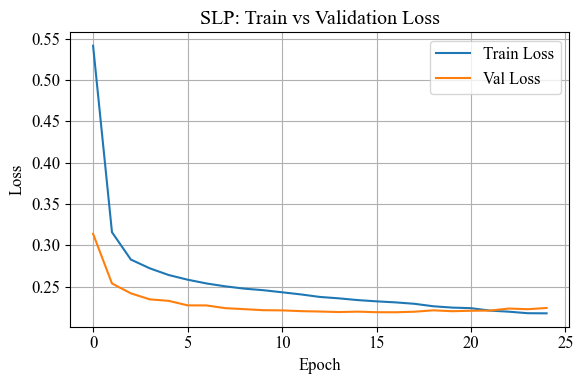

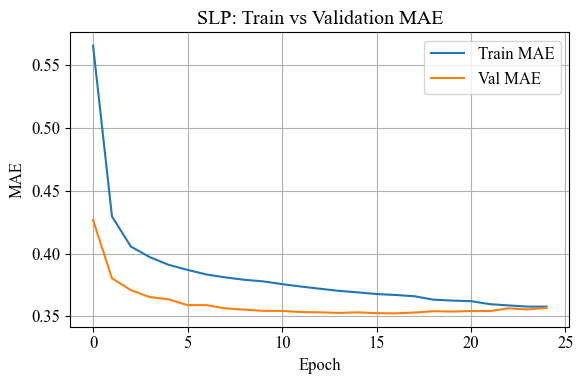

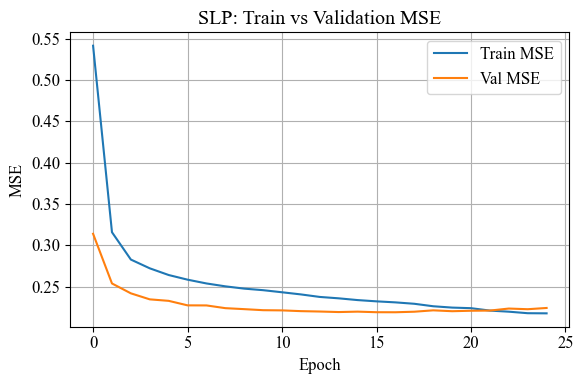

In [35]:
plot_train_process(msl_history, 'SLP')

101/101 [==============================] - 0s 5ms/step
Mean_rmse:3791.375
Mean_mae:2943.236572265625
Mean_r2:0.7700584530830383
---------- PCA MODES PREDICTION DISPALY ----------


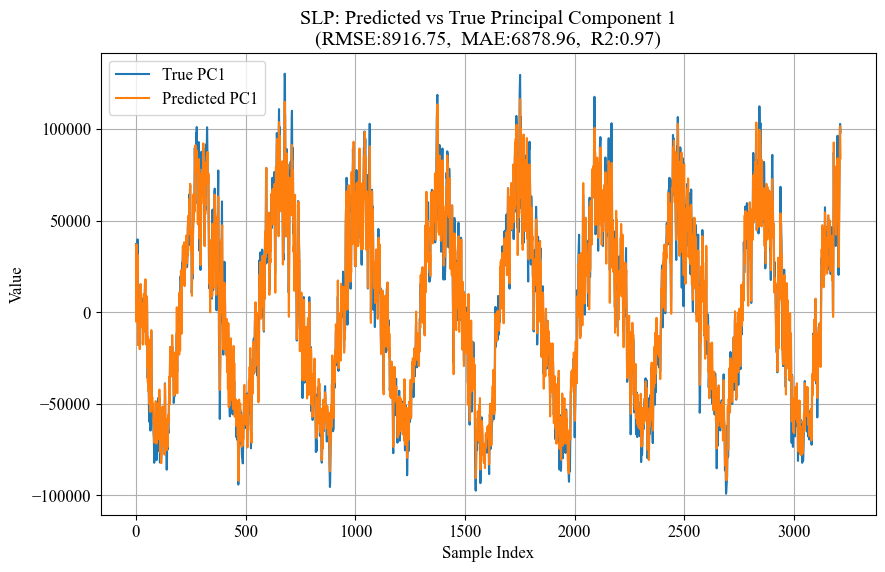

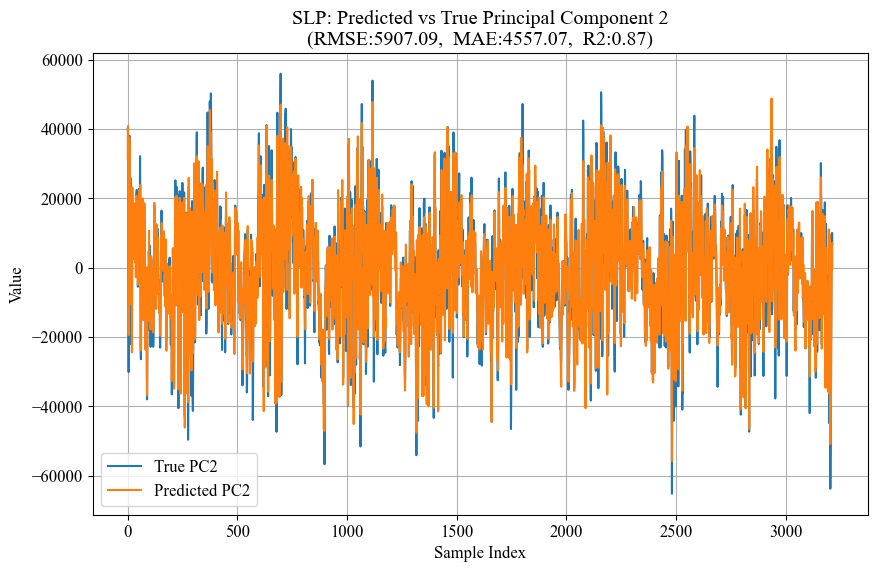

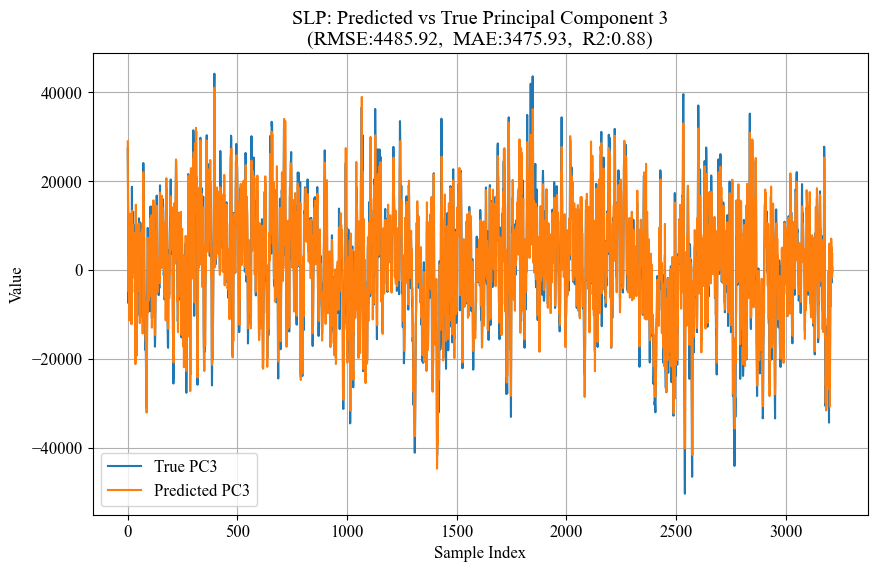

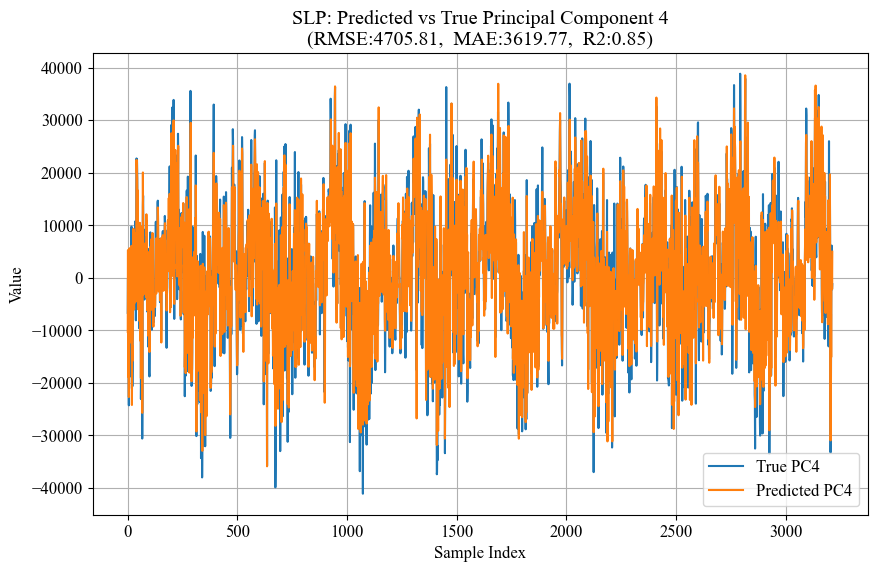

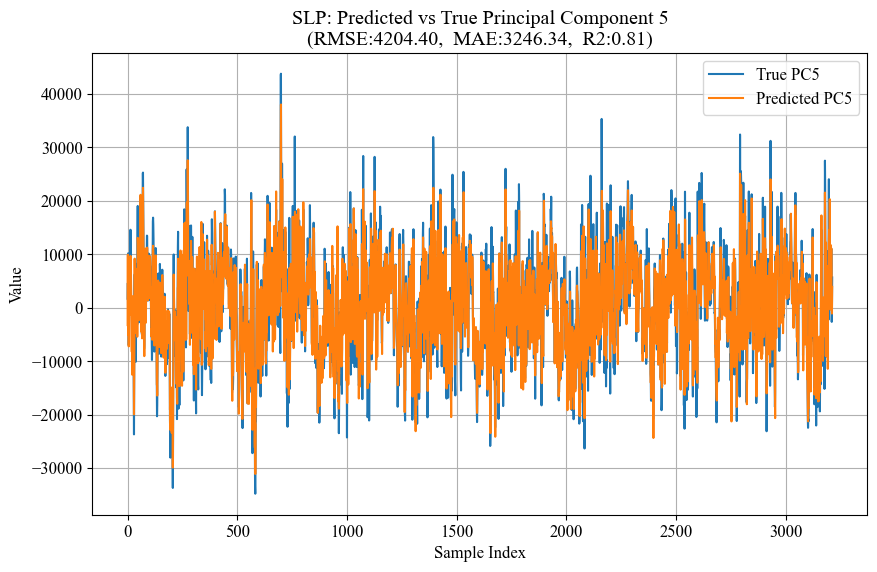

In [38]:
msl_y_pred = msl_model.predict(msl_x_test)
msl_lstm_mse, msl_lstm_mae, msl_lstm_r2 = eval_metrics_calculation(scaler_msl.inverse_transform(msl_y_pred), scaler_msl.inverse_transform(msl_y_test),\
                                                                   5, 'SLP')

## 3.2 T2M：LSTM Prediction 

### Data Normalization and Splitting

In [39]:
n_steps = 10

scaler_t2m = StandardScaler()
t2m_pca_scaled = scaler_t2m.fit_transform(t2m_pca)
t2m_x_seq, t2m_y_seq = create_sequences(t2m_pca_scaled, n_steps)

train_ratio = 0.8
split_idx = int(len(t2m_x_seq) * train_ratio)
t2m_x_train, t2m_x_test = t2m_x_seq[:split_idx], t2m_x_seq[split_idx:]
t2m_y_train, t2m_y_test = t2m_y_seq[:split_idx], t2m_y_seq[split_idx:]

### Model Construction

In [40]:
t2m_model = Sequential()
t2m_model.add(LSTM(128, return_sequences=False, input_shape=(t2m_x_train.shape[1], t2m_x_train.shape[2])))
t2m_model.add(Dropout(0.2))
t2m_model.add(Dense(t2m_x_train.shape[2]))

t2m_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

### Train

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

t2m_history = t2m_model.fit(
    t2m_x_train, t2m_y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(t2m_x_test, t2m_y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
402/402 [==============================] - 5s 10ms/step - loss: 0.4495 - mae: 0.5050 - mse: 0.4495 - val_loss: 0.2848 - val_mae: 0.3994 - val_mse: 0.2848
Epoch 2/1000
402/402 [==============================] - 4s 10ms/step - loss: 0.2757 - mae: 0.3952 - mse: 0.2757 - val_loss: 0.2307 - val_mae: 0.3565 - val_mse: 0.2307
Epoch 3/1000
402/402 [==============================] - 3s 7ms/step - loss: 0.2504 - mae: 0.3753 - mse: 0.2504 - val_loss: 0.2199 - val_mae: 0.3472 - val_mse: 0.2199
Epoch 4/1000
402/402 [==============================] - 4s 9ms/step - loss: 0.2395 - mae: 0.3669 - mse: 0.2395 - val_loss: 0.2149 - val_mae: 0.3416 - val_mse: 0.2149
Epoch 5/1000
402/402 [==============================] - 4s 10ms/step - loss: 0.2342 - mae: 0.3625 - mse: 0.2342 - val_loss: 0.2107 - val_mae: 0.3387 - val_mse: 0.2107
Epoch 6/1000
402/402 [==============================] - 3s 7ms/step - loss: 0.2289 - mae: 0.3583 - mse: 0.2289 - val_loss: 0.2097 - val_mae: 0.3372 - val_mse: 0.2097
E

### Evaluation

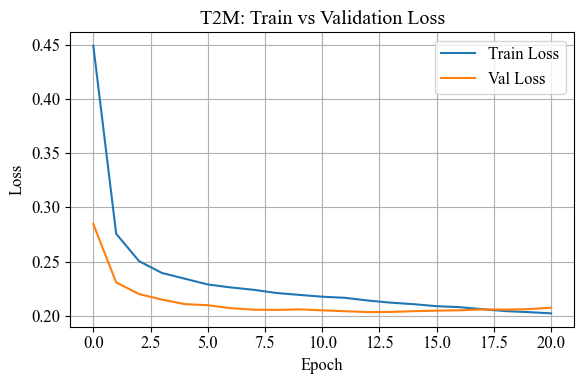

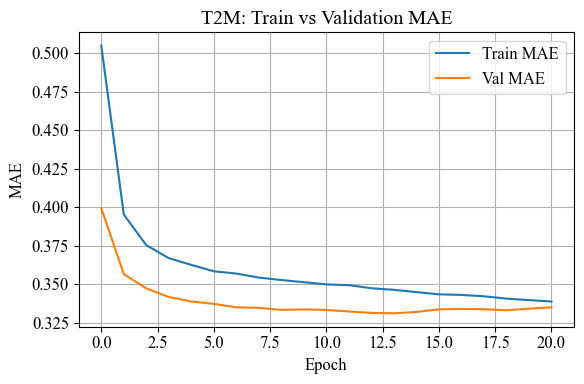

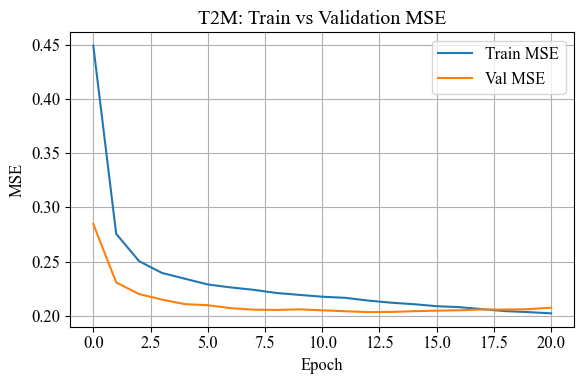

In [42]:
plot_train_process(t2m_history, 'T2M')

101/101 [==============================] - 1s 6ms/step
Mean_rmse:20.159839630126953
Mean_mae:15.71411418914795
Mean_r2:0.784846842288971
---------- PCA MODES PREDICTION DISPALY ----------


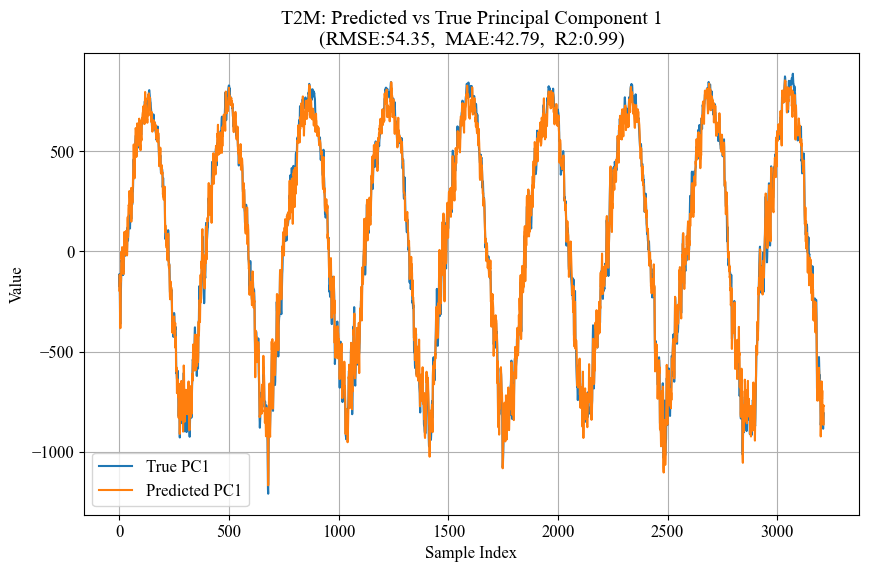

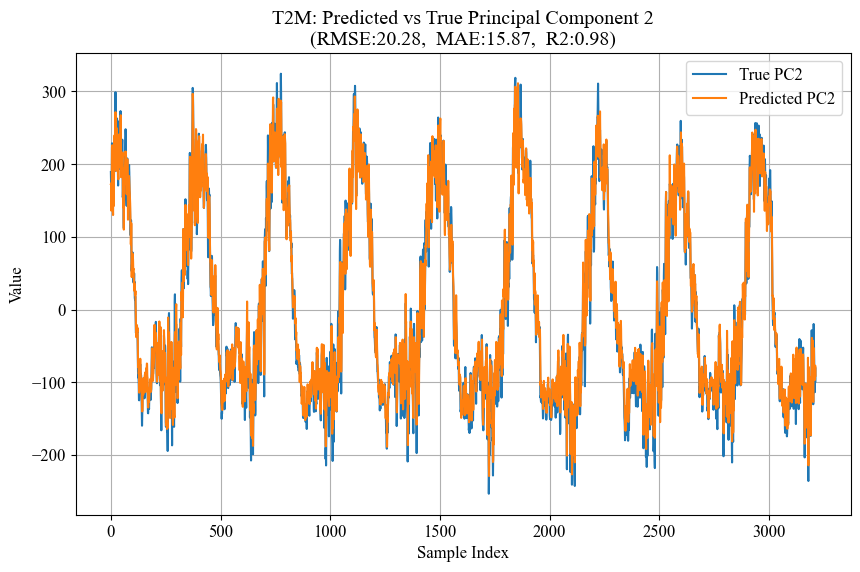

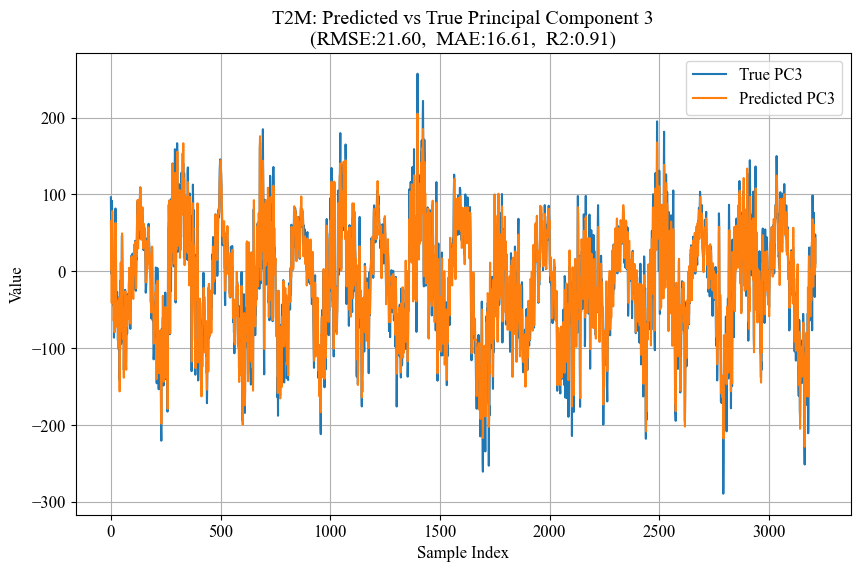

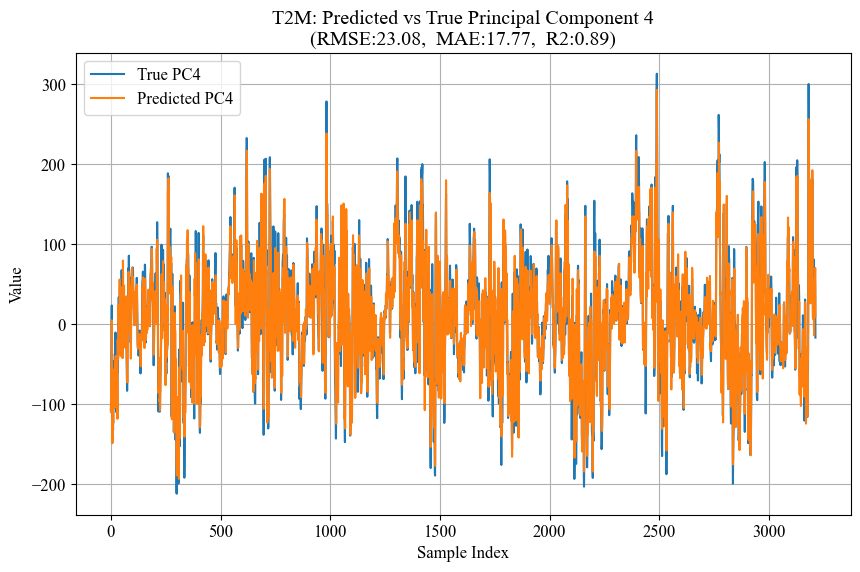

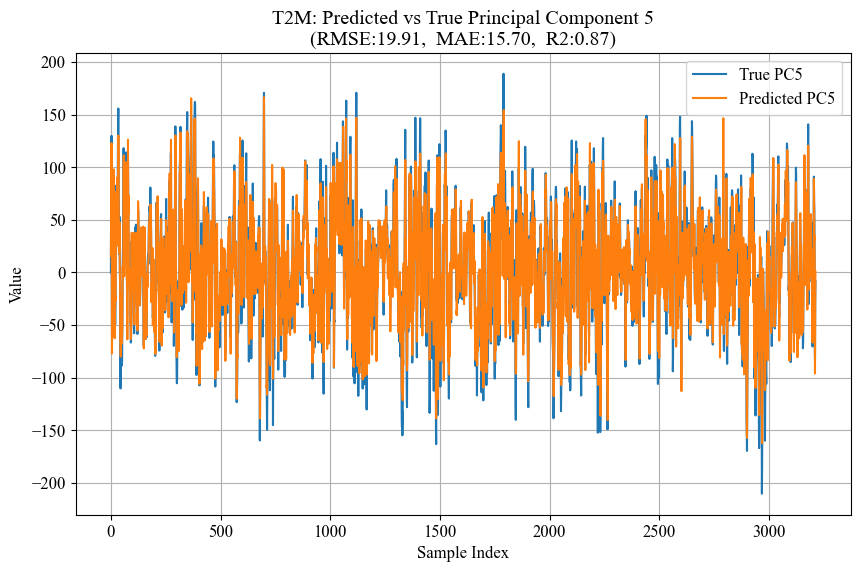

In [43]:
t2m_y_pred = t2m_model.predict(t2m_x_test)
t2m_lstm_mse, t2m_lstm_mae, t2m_lstm_r2 = eval_metrics_calculation(scaler_t2m.inverse_transform(t2m_y_pred), scaler_t2m.inverse_transform(t2m_y_test),\
                                                                   5, 'T2M')